# Phases and Phase Transitions

In [1]:
using GLMakie
using CairoMakie
using OffsetArrays
using Random
using ProgressMeter
using Statistics
using DataStructures
using LinearAlgebra
using LaTeXStrings
using HDF5
using Polynomials
CairoMakie.activate!(type = "png")

Here is my version of the Wolf Algorithm code from the last lab:

In [2]:
"""
    wolfupdate!(s,pbar,numclusters)

Called with an array of spins `s`, the probability `pbar=exp(-2beta J)` and the number of clusters to be flipped.  Runs the 
Wolf algorithm `numclusters` times.  Returns the number of flipped spins.
"""
function wolfupdate!(s,pbar #=exp(-2beta)=#,numclusters)
    m, n = sz = size(s)
    numflipped=0
    neighbors=CartesianIndex{2}[]
    loc=rand(CartesianIndices(sz))
    for sweep in 1:numclusters
        loc=rand(CartesianIndices(sz))
        σ=s[loc]
        s[loc]=-σ
        numflipped+=1
        pushneighbors!(neighbors,loc,sz)
        while length(neighbors)>0
            nb=pop!(neighbors)
            if s[nb]!=σ 
                continue
            end
            if rand()<pbar
                continue
            end
            s[nb]=-σ
            numflipped+=1
            pushneighbors!(neighbors,nb,sz)
        end
    end
    return numflipped
end 

"""
    pushneighbors!(neighbors,ind,sz)

`ind` corresponds to a `CartesianIndex` object corresponding to the position of a spin.
`pushneighbors` adds its neighbors to the list `neighbors`
`sz` is the size of the array -- so that we can implement periodic boundaries.
"""
@inline function pushneighbors!(neighbors,ind,sz)
    i=ind[1]
    j=ind[2]
    (m,n)=sz
    τ₁=CartesianIndex(mod1(i-1,m),j)
    τ₂=CartesianIndex(mod1(i+1,m),j)
    τ₃=CartesianIndex(i,mod1(j-1,n))
    τ₄=CartesianIndex(i,mod1(j+1,n))
    push!(neighbors,τ₁)
    push!(neighbors,τ₂)
    push!(neighbors,τ₃)
    push!(neighbors,τ₄)
end

rand_ising2d(m=128, n=m) = rand(Int8[-1, 1], m, n)

rand_ising2d (generic function with 3 methods)

The only thing noteworthy in my code is that I decided to use `CartesianIndex` objects.  These are container objects -- like `Array`s or `Tuple`s 

In [15]:
ind=CartesianIndex(2,3)

CartesianIndex(2, 3)

In [16]:
s1=rand_ising2d(8)

8×8 Matrix{Int8}:
 -1  -1   1  -1  -1  -1  -1  -1
 -1   1  -1   1  -1   1   1   1
  1  -1  -1   1  -1  -1   1   1
 -1  -1  -1   1   1  -1   1   1
 -1  -1   1  -1   1  -1   1  -1
  1   1   1  -1  -1   1  -1  -1
  1  -1  -1  -1   1   1   1  -1
  1   1  -1  -1  -1   1   1  -1

In [17]:
s1[ind]

-1

In [18]:
ind2=CartesianIndex(1,1)

CartesianIndex(1, 1)

You can add them together just like arrays

In [19]:
ind+ind2

CartesianIndex(3, 4)

We then wrote functions which would then loop over `wolfupdate!` -- running it multiple times.

In [3]:
function wolfsimulate(m::Int64,n::Int64,β::Float64,h::Float64,
        innersweeps::Int64,outersweeps::Int64)
    s=rand_ising2d(m,n)
    wolfsimulate!(s,β,h,innersweeps,outersweeps)
end

function wolfsimulate!(s,β::Float64,h::Float64,
        innersweeps::Int64,outersweeps::Int64)
    pbar=exp(-2*β)
    # Create empty lists for storing the energies and magnetizations
    Elist=Float64[]
    maglist=Float64[]
    fliplist=Float64[]
    # next do the outer loop
    for outer in 1:outersweeps
        f=wolfupdate!(s,pbar,innersweeps)
        E=Energy(s,h)
        mag=Magnetization(s)
        push!(Elist,E)
        push!(maglist,mag)
        push!(fliplist,f)
    end
    return (Elist=Elist ,maglist=maglist, 
        fliplist=fliplist,dims=size(s) ,β=β ,h=0 ,innersweeps=innersweeps)
end

function Energy(s #=spin configuration=#,h)
    m, n = size(s)
    E=0.
    @inbounds for i in 1:m
        @inbounds for j in 1:n
            E+=-s[i,j]*(h+s[mod1(i+1,m),j]+s[i,mod1(j+1,n)])
        end
    end
    return E/(m*n)
end

Magnetization(s#=spin configuration=#)=mean(s)

Magnetization (generic function with 1 method)

One inconvenience with `wolfsimulate` is that you need to know what to set `innersweeps` to, and you also need to first equilibrate your input.  Here is a function which does that for you:

In [4]:
function fullsimulate!(
        s,β::Float64,h::Float64,
        burnsweeps::Int64,outersweeps::Int64)
    m,n=size(s)
    # do a short run to extract average cluster size
    shortrun=wolfsimulate!(s,β,0.,10,1)
    averageclustersize=mean(shortrun.fliplist)/10
    innersweeps=round(Int64,m*n/averageclustersize)
    if burnsweeps*innersweeps>10
        # complete the burn
        burnsteps=burnsweeps*innersweeps-10
        burn=wolfsimulate!(s,β,0.,burnsweeps*innersweeps-10,1)
    end
    # do another short run to 
    # extract new average cluster size
    shortrun=wolfsimulate!(s,β,0.,10,1)
    averageclustersize=mean(shortrun.fliplist)/10
    # do final run of algorithm
    innersweeps=ceil(Int64,m*n/(10*averageclustersize))
    result=wolfsimulate!(s,β,0.,innersweeps,outersweeps)
    return(;result...,innersweeps=innersweeps)
end


fullsimulate! (generic function with 1 method)

Finally you wrote some code to do a temperature sweep, and save the data:

In [22]:
mutable struct Sweepdata
    arraysize
    betas
    maglists
    Elists
end

function savesweep(data::Sweepdata,filename::String)
    h5open(filename,"w") do file
        write(file,"arraysize",[data.arraysize...])
        write(file,"betas",Float64[data.betas...])
        write(file,"maglists",hcat(data.maglists...))
        write(file,"Elists",hcat(data.Elists...))
    end
end

savesweep(filename::String,data::Sweepdata)=savesweep(data,filename)

function loadsweep(filename::String)
    datastream=h5open(filename, "r")
    arraysize=read(datastream["arraysize"])
    betas=read(datastream["betas"])
    maglists=read(datastream["maglists"])
    Elists=read(datastream["Elists"])
    return Sweepdata(
        Tuple(arraysize),
        betas,
        [m[:] for m in eachcol(maglists)],
        [e[:] for e in eachcol(Elists)])
end

function tempsweep(m,n,initialbeta,finalbeta,betastep,burnsweeps,outersweeps)
    s=rand_ising2d(m,n)
    β=initialbeta
    arraysize=(m,n)
    energylists=[]
    maglists=[]
    betalist=[]
    while β*betastep<=finalbeta*betastep  #multiply be betastep so get right condition when betastep is negative
        run=fullsimulate!(s,β,0.,burnsweeps,outersweeps)
        push!(energylists,run.Elist)
        push!(maglists,run.maglist)
        push!(betalist,β)
        β+=betastep
    end
    return Sweepdata(arraysize,betalist,maglists,energylists)
end 

tempsweep (generic function with 1 method)

In [23]:
# Generate Data, and save it
#for j in 3:10
#    println("generating data for j="*string(j))
#    @time data=tempsweep(2^j,2^j,0.2,0.8,0.02,10,1000)
#    filename="swp"*string(j)*".h5"
#    savesweep(data,filename)
#    println("saved data in file "*string(filename))
#    println()
#end

Here is how we ask the computer for a list of all of the file names with the right syntax

In [24]:
datafiles=[file for file in readdir() if startswith(file,"swp")]

8-element Vector{String}:
 "swp10.h5"
 "swp3.h5"
 "swp4.h5"
 "swp5.h5"
 "swp6.h5"
 "swp7.h5"
 "swp8.h5"
 "swp9.h5"

To get the order right, however, I'll just make the file names by hand:

In [25]:
sdatafile=["swp"*string(j)*".h5" for j in 3:10]

8-element Vector{String}:
 "swp3.h5"
 "swp4.h5"
 "swp5.h5"
 "swp6.h5"
 "swp7.h5"
 "swp8.h5"
 "swp9.h5"
 "swp10.h5"

In [26]:
data=[loadsweep(file) for file in sdatafile];

Now lets plot the data.  Here is the program, from the lab, which calculates the mean and error in any quantity, from a time-series.

In [27]:
"""
    stats(timeseries,numbins=10)
    stats(obj,key::Symbol,transform,numbins=10)

The base version takes a timeseries of some quantity, and bins it into `numbins` bins.  
Assuming the data in the bins is independent, it calculates the mean and estimates the error in the mean.

The alternative version takes an arbitary object `obj` a key `key`, and a function `transform`.  It takes `obj.key` 
-- which should be a list of datasets.  It then applies `transform` to each element, and calculates the
mean and error.
"""
function stats(timeseries,numbins=10)
    m=mean(timeseries)
    len=length(timeseries)
    binlength=floor(Int64,len/numbins)
    bins=[sum(timeseries[j+1:j+binlength])/binlength for j in 0:binlength:(numbins-1)*binlength]
    err=sqrt((bins⋅bins-numbins*m^2)/numbins^2)
    return m,err
end

stats(obj,key::Symbol,transform,numbins=10)=
    [stats(transform(ser),numbins) for ser in getfield(obj,key)]


stats (generic function with 4 methods)

For example we can use this to extract the absolute value of the magnetization

One strategy is to take just our largest system size, and take that as an approximation to the thermodynamic limit:

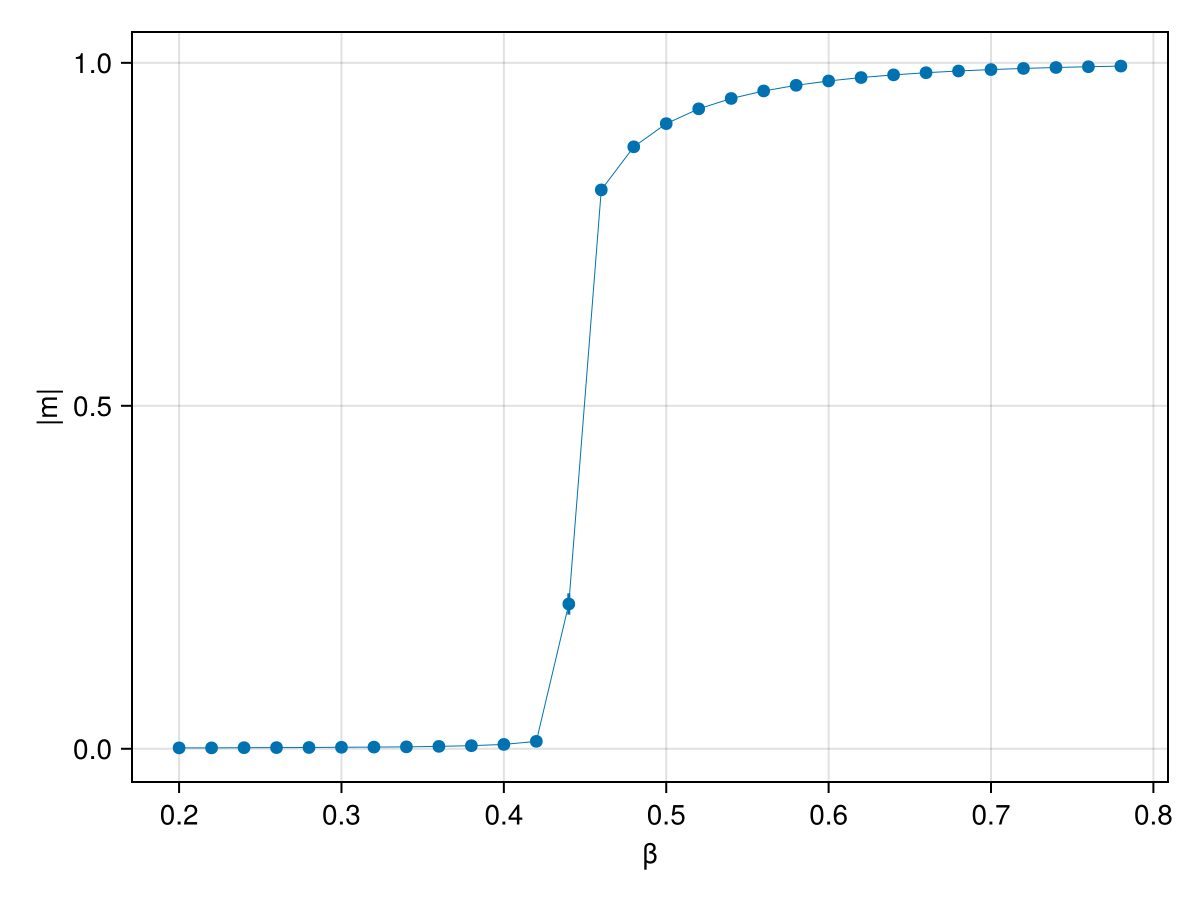

In [28]:
f=Figure()
ax=Axis(f[1,1],xlabel="β",ylabel="|m|")

set=data[end] # Take the last dataset
betas=[set.betas...] # Extract the temperatures
ave_error=stats(set,:maglists,x->abs.(x)) # extract the magnetizations, and calculate error bars
ave=[m[1] for m in ave_error] # average magnetizations
err=[m[2] for m in ave_error] # errors
plot!(ax,betas,ave,label=string(set.arraysize))
errorbars!(ax,betas,ave,err)
lines!(ax,betas,ave,linewidth=0.5)
f

Clearly the magnetization is small for $\beta<0.42$ -- this is the high temperature paramagnet.  It is large for $\beta>0.44$ -- the is the low temperature ferromagnet.  The transition is quite abrupt -- much sharper than a "mean-field" transition.  The error bars are tiny.  You see some signatures of finite size effects.

We learn more by looking at "finite size scaling" -- or how the answer depends on system size

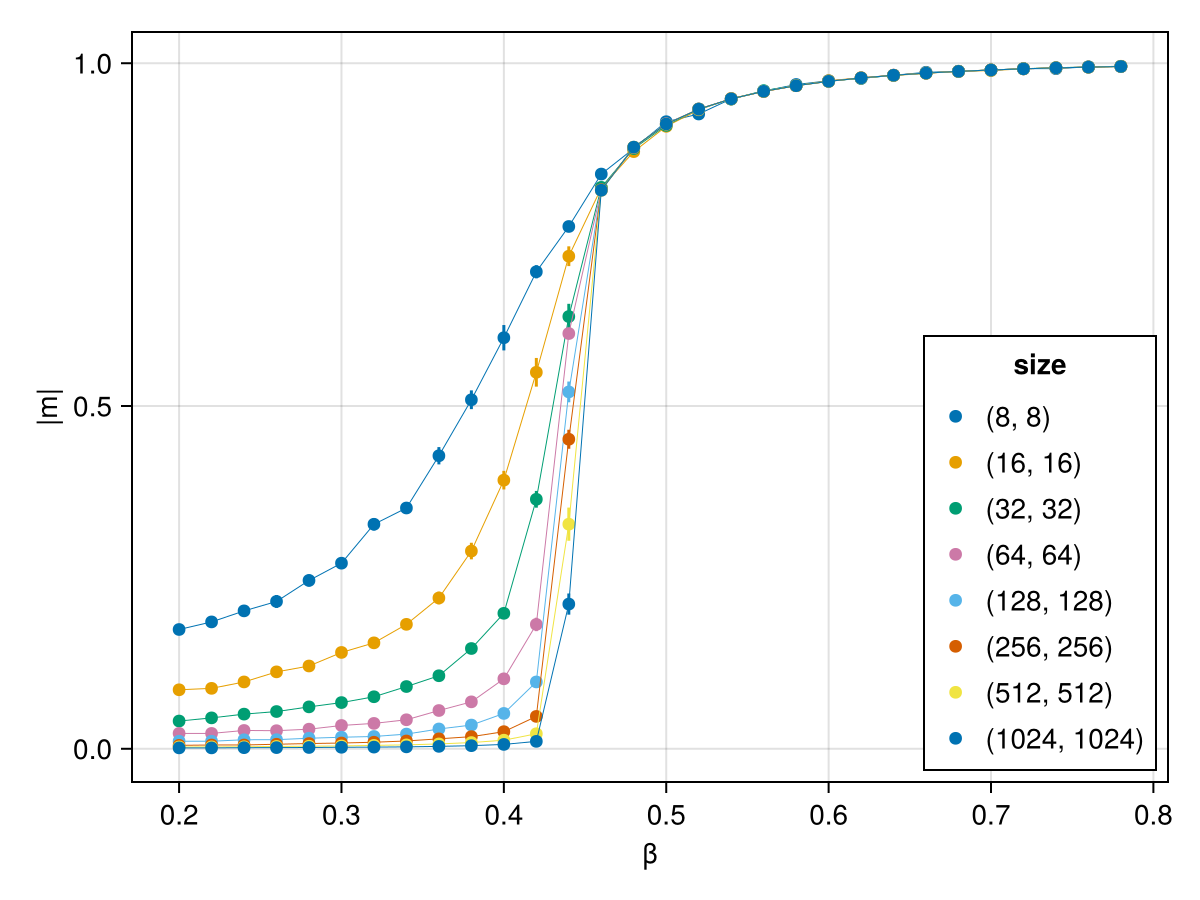

In [29]:
f=Figure()
ax=Axis(f[1,1],xlabel="β",ylabel="|m|")
for set in data # loop over the data sets
    betas=[set.betas...]
    ave_error=stats(set,:maglists,x->abs.(x))
    ave=[m[1] for m in ave_error]
    err=[m[2] for m in ave_error]
    plot!(ax,betas,ave,label=string(set.arraysize))
    errorbars!(ax,betas,ave,err)
    lines!(ax,betas,ave,linewidth=0.5)
end
axislegend("size", position = :rb)
f       

As you can see, in the thermodynamic limit there appears to be some sort of non-analytic behavior around $\beta=0.44$.  For larger $\beta$ (lower temperature) $|m|$ appears to have a finite expectation value.  For smaller $\beta$ (higher temperature), instead the average appears to approach zero.

The low temperature phase is the ferromagnet, where the spins are aligned.  The high temperature phase is the paramagnet, where the spins point in random directions.

Another way to display the data is to show $|m|$ vs $1/L$ for various temperatures

In [30]:
# get a list of the betas
betas=[data[1].betas...]
# get a list of the sizes
sizes=[d.arraysize[1] for d in data]
numbetas=length(betas)  # how many different temperatures do we have?
numsizes=length(sizes)  # how many different sizes
mdata=zeros(numsizes,numbetas) # blank array for storing magnetizations
edata=zeros(numsizes,numbetas) # blank array for storing energies
for jb in 1:numbetas
    for js in 1:numsizes 
        timeseries=abs.(data[js].maglists[jb])
        ave_error=stats(timeseries)
        mdata[js,jb]=ave_error[1]
        edata[js,jb]=ave_error[2]
    end
end

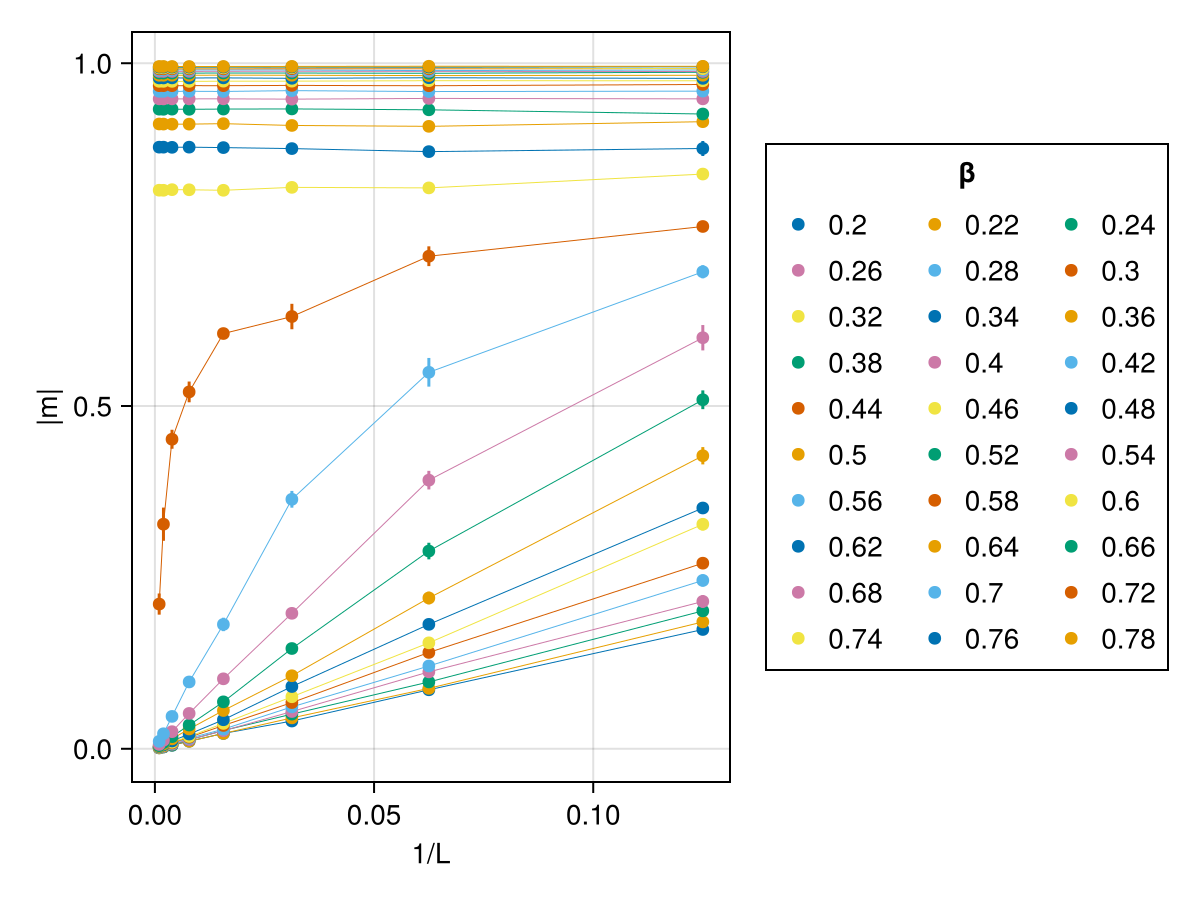

In [31]:
f=Figure()
ax=Axis(f[1,1],xlabel="1/L",ylabel="|m|")
plist=[]
for jb in 1:numbetas
    p=plot!(ax,1 ./sizes,mdata[:,jb])
    push!(plist,p)
    errorbars!(ax,1 ./sizes,mdata[:,jb],edata[:,jb])
    lines!(ax,1 ./sizes,mdata[:,jb],linewidth=0.5)
end
Legend(f[1,2],plist,[string(round(b,sigdigits=2)) for b in betas],"β",nbanks=3)
f      

As we already saw, there is some sort of discontinuity in the thermodynamic limit between $\beta=0.44$ and $\beta=0.46$.  That is the phase transition.  This finite-size scaling is the classic approach to finding the transition.  In a future lecture we will see that there are a number of refinements which will help us be more precise (and get error bars).

We can learn more about what is going on by not only looking at the means, but looking at the entire distribution

In [32]:
hotind=8
midind=13
coldind=18
@show betahot=data[1].betas[hotind]
@show betamid=data[1].betas[midind]
@show betacold=data[1].betas[coldind];

betahot = (data[1]).betas[hotind] = 0.3400000000000001
betamid = (data[1]).betas[midind] = 0.44000000000000017
betacold = (data[1]).betas[coldind] = 0.5400000000000003


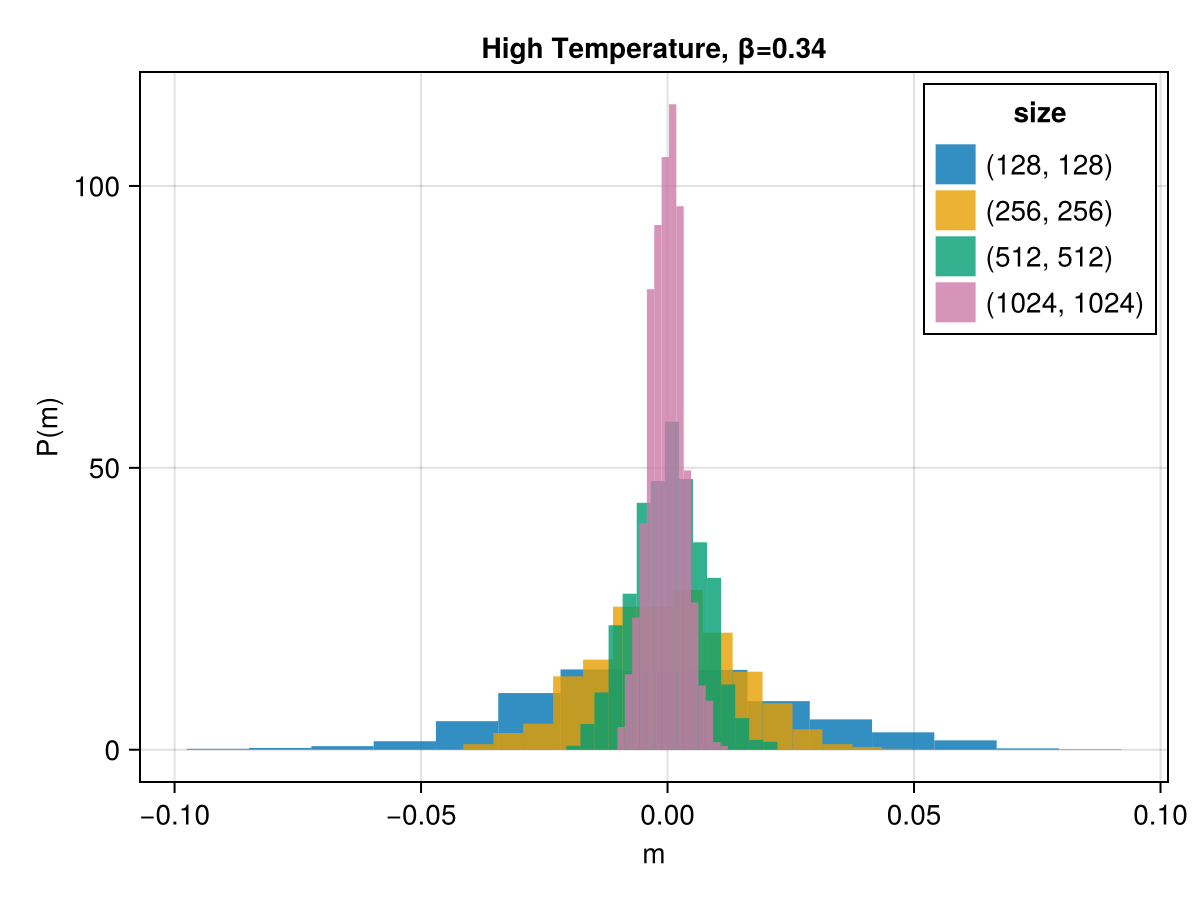

In [33]:
bnum=hotind
f=Figure()
ax=Axis(f[1,1],title="High Temperature, β="*string(round(data[1].betas[bnum],sigdigits=2)),
    xlabel="m",ylabel="P(m)")
for set in data[5:end]
    hist!(ax,set.maglists[bnum],normalization=:pdf,
        label=string(set.arraysize))
end
axislegend("size", position = :rt)
f

At high temperature, the magnetization fluctuations around zero.  When we calculated $\langle |m|\rangle$, we are picking up the width of this Gaussian.  This width scales as $1/\sqrt{N}$ where $N=L^2$ is the number of spins

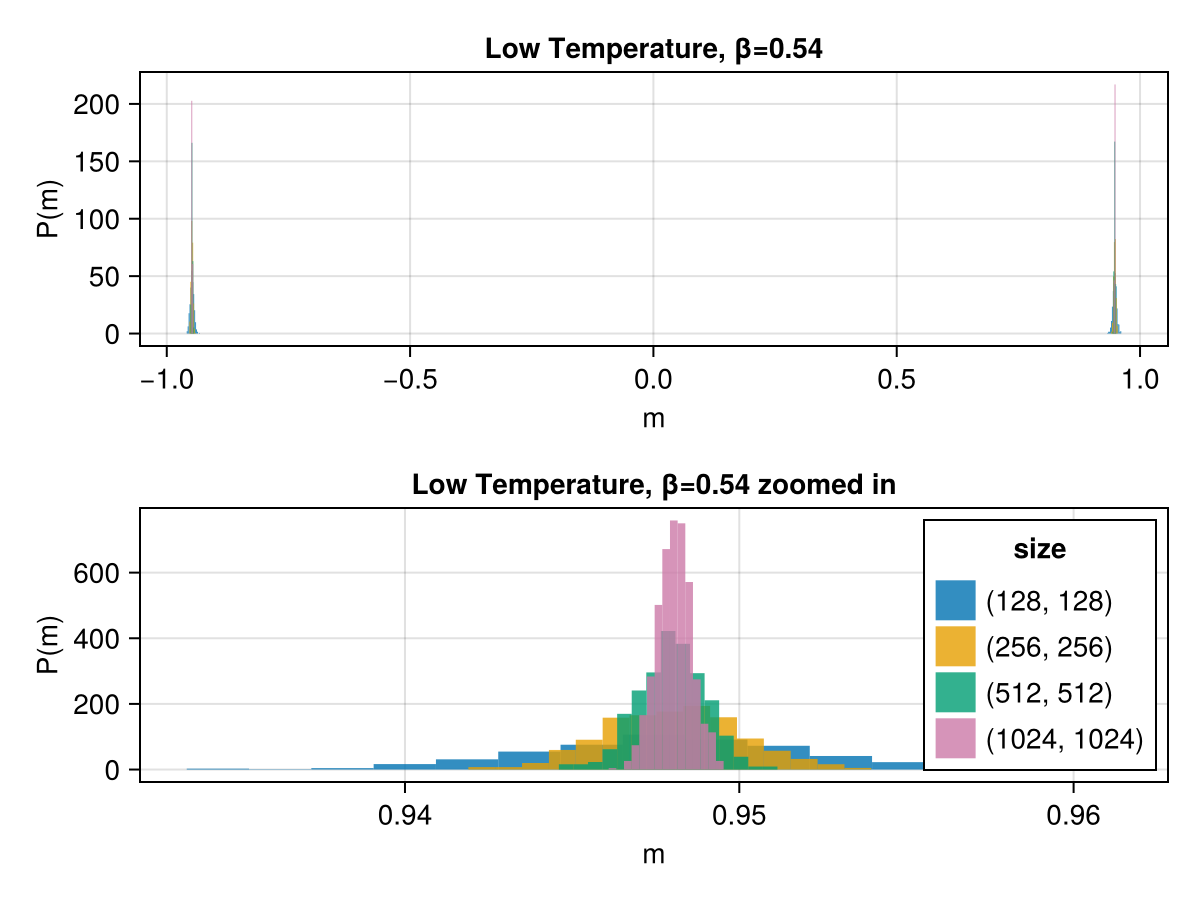

In [34]:
bnum=coldind
f=Figure()
ax=Axis(f[2,1],
    title="Low Temperature, β="*string(round(data[1].betas[bnum],sigdigits=2))*" zoomed in",
    xlabel="m",ylabel="P(m)")
ax2=Axis(f[1,1],
    title="Low Temperature, β="*string(round(data[1].betas[bnum],sigdigits=2)),
    xlabel="m",ylabel="P(m)")
for set in data[5:end]
    hist!(ax,abs.(set.maglists[bnum]),normalization=:pdf,
        label=string(set.arraysize))
    hist!(ax2,(set.maglists[bnum]),normalization=:pdf,
        label=string(set.arraysize),bins=1000)
end
axislegend(ax,"size", position = :rt)
f

At low temperature, instead, the distribution function of the magnetization has two Gaussian peaks at finite $\pm m$, whose width shrinks as we increase the system size.

(1) Can we understand these two behaviors?
(2) Can we use that behavior to help us find the phase transition point?

## Understanding these probability distributions

Lets construct typical configurations at these temperatures:

  2.425342 seconds (166.67 k allocations: 11.093 MiB, 3.57% compilation time)


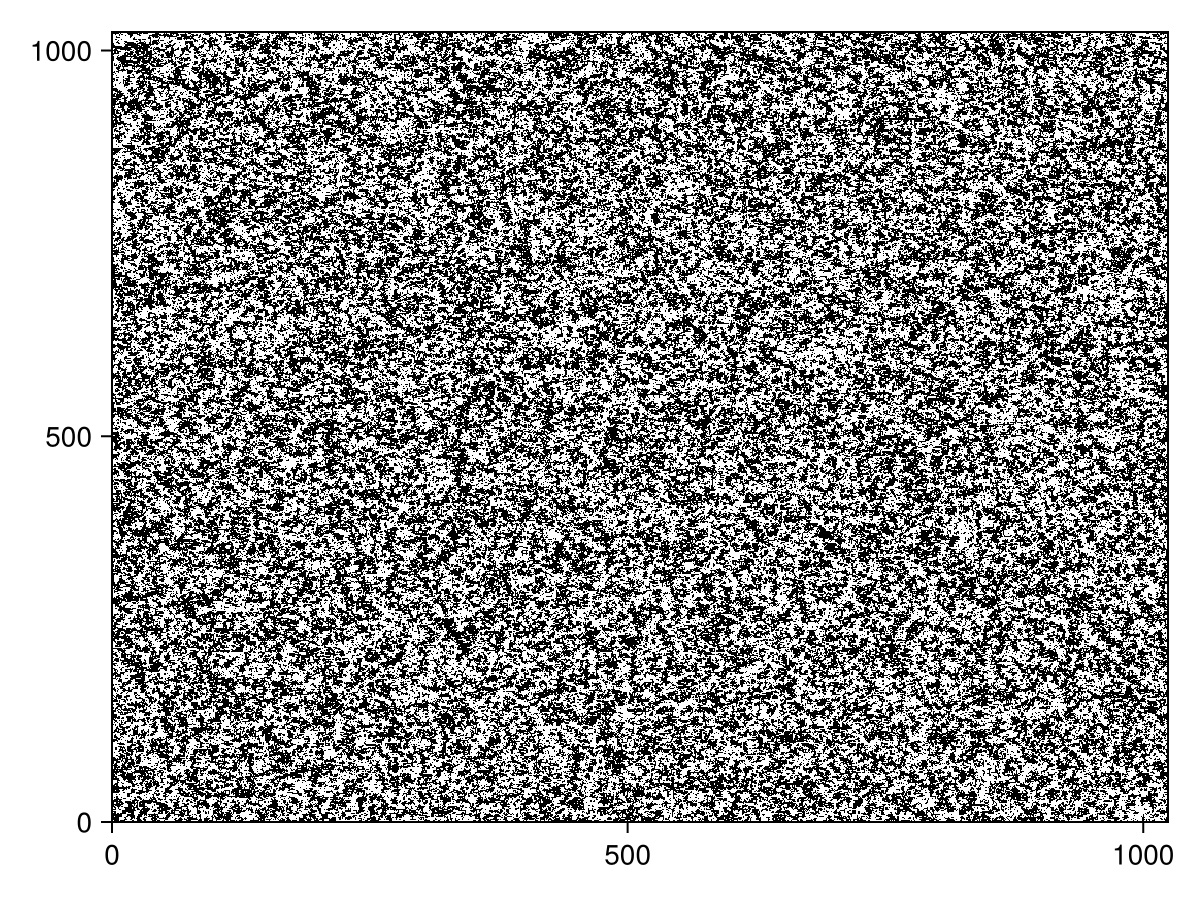

In [35]:
CairoMakie.activate!(type="png")
sh=rand_ising2d(1024,1024)
@time fullsimulate!(sh,betahot,0.,10,1)
im=image(sh,interpolate=false)

Lets zoom in

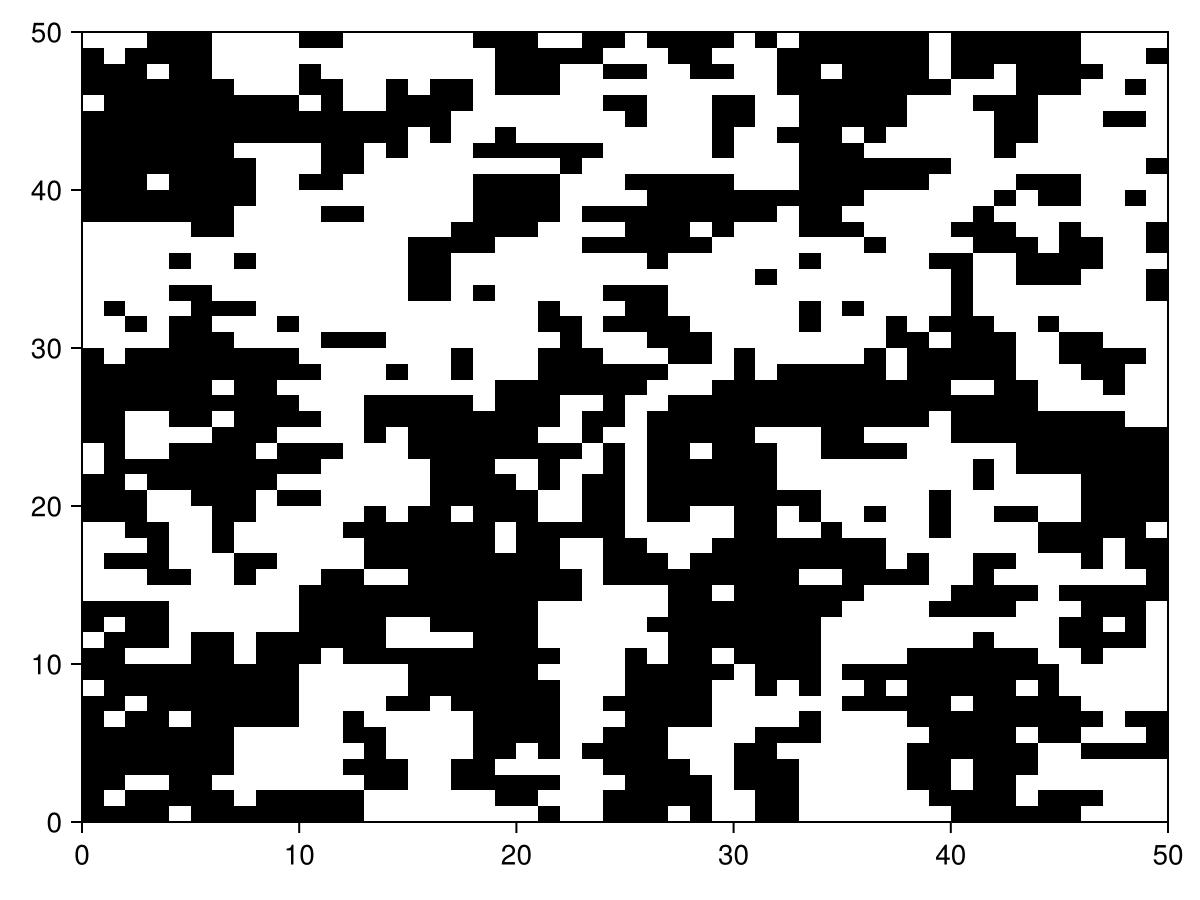

In [36]:
image(sh[1:50,1:50],interpolate=false)

There is clearly a characteristic length here -- which is of order 10 sites.  Spins separated by larger distance than that are independent.  Lets break the system up into these independent domains, with magnetization $m_1,m_2,\cdots,m_S$.  Here $S$ is the number of such domains.  By definition, the total magnetization $m$ is equal to $m_1+m_2+\cdots m_S=S*m$.

We know that the probability distribution of the sum of a large number of random variables is a Gaussian:

\begin{align}
\langle m\rangle &= \frac{1}{S}\sum_{j=1}^S \langle m_j\rangle\\
\langle m^2\rangle-\langle m\rangle^2 &= \frac{1}{S^2}\sum_{i=1}^S \sum_{j=1}^s \langle m_i m_j\rangle - \langle m_i\rangle \langle m_j\rangle\\
&= \frac{1}{S^2}\sum_{j=1}^S \langle m_j^2\rangle -\langle m_j\rangle^2\\
&= \frac{\sigma}{S}
\end{align}

and hence

\begin{equation}
P(m)\propto \exp\left(-\frac{S}{2} \frac{(m-\bar m)^2}{\sigma^2}\right)
\end{equation}

We further note that $S$ is proportional to the total number of spins in the system $N$, and hence

\begin{equation}
P(m)\propto \exp\left(-N \frac{(m-\bar m)^2}{2\lambda^2}\right)
\end{equation}

where $\lambda$ characterizes the width of the distribution.

## Free Energy

Another way to think about this is that $P(m)$ is equal to the average of the Boltzmann factor over all configuration with total magnetization $m$:
\begin{align}
P(m)&\propto\sum_{\{\sigma\}} 
\exp\left(-\beta E_{\{\sigma\}}\right)
\delta_{m=\sum_j \sigma_j}
\end{align}
We define the average energy of the configurations with magnetization $m$ to be $E$.  Then
\begin{align}
P(m)&\propto \exp\left(-\beta E \right) \Omega_m
\end{align}
where $\Omega_m$ is the number of configurations with magnetization $m$.  We define the entropy $S=k_B \ln \Omega$, and hence
\begin{align}
P(m)&\propto \exp\left(-\beta (E-T S)\right)\\
&=\exp -\beta F.
\end{align}
This defines the free energy
\begin{equation}
F(m) = E-T S.
\end{equation}

The name "free energy" is a bit archaic, but for our purposes it is just the logarithm of the probability distribution of a macroscopic variable.  It is not just the energy, because it takes into account that there are many microstates which give the same macrostate.

The free energy scales with the system size, and hence it is natural to think of it as a sum over a local free-energy density $f=F/N$.

We can try to extract this free energy density from our probability distributions -- and we expect it to be a quadratic function of $m$, at high temperature.

To do this extraction, we need to bin our data:

In [37]:
mutable struct Bin
    min ::Float64
    max ::Float64
    step ::Float64
    counts ::Array{Int64,1}
    under ::Int64
    over ::Int64
end

## Constructors

### Basic Constructor
function Bin(min,max,numbins)
    step=(max-min)/numbins
    counts=zeros(Int64,numbins)
    Bin(min,max,step,counts,0,0)
end

### Named Constructor -- allowing one to specify either numbins or step
function Bin(;min,max,numbins=0,step=0)
    if numbins==0 && step==0
        throw("Bin must be constructed with either `numbin` or `step` arguments")
    end
    if step==0
        return Bin(min,max,numbins)
    end
    numbins=Int64(round((max-min)/step))
    MAX=min+numbins*step
    return Bin(min,MAX,numbins)
end

function (b::Bin)(val)
    if val<b.min
        b.under+=1
        return b
    end
    if val>=b.max
        b.over+=1
        return b
    end
    bnum=1+Int64(floor((val-b.min)/b.step))
    b.counts[bnum]+=1
    return b
end

Base.push!(b::Bin,val)=b(val)

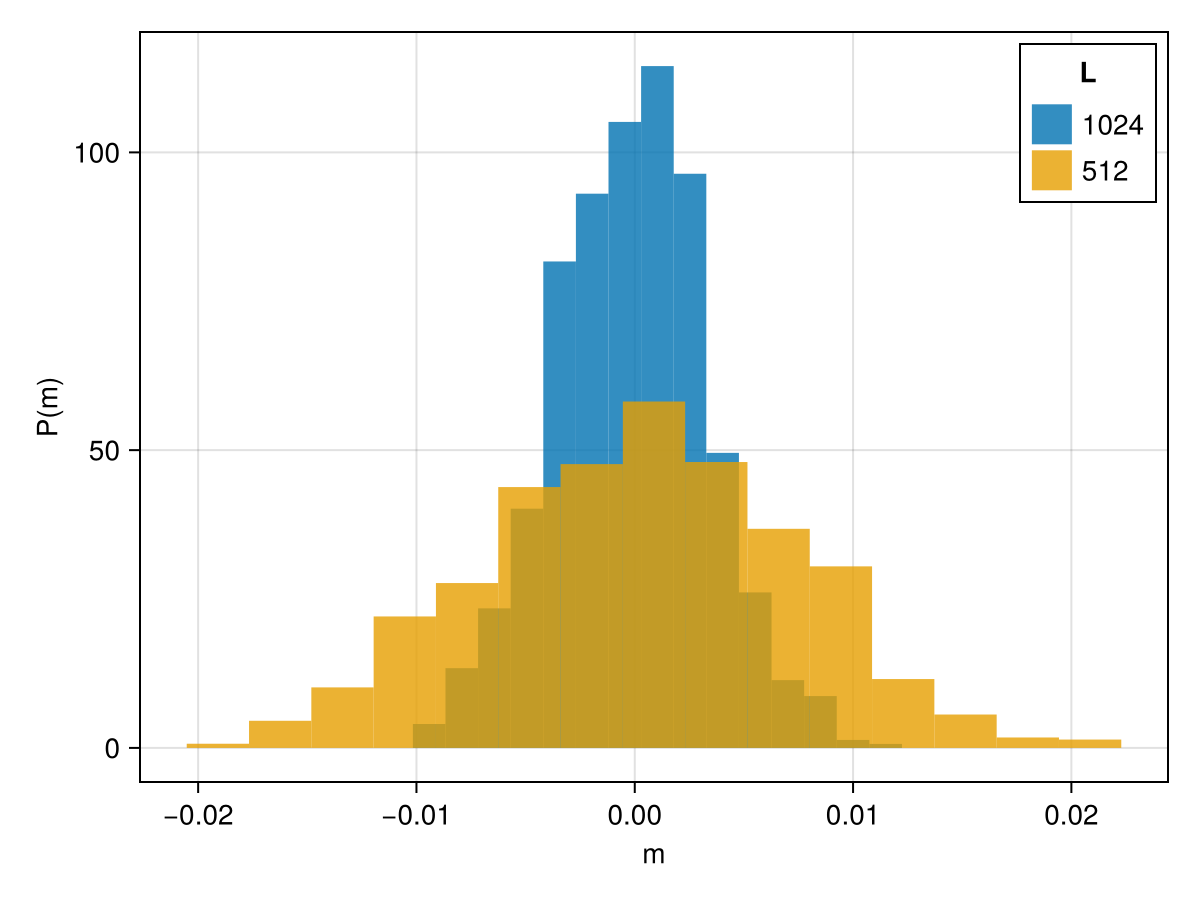

In [38]:
# Get magnetization data for 1024x1024 system
# for one high temperature 
mht1024=data[end].maglists[8]
# Get magnetization data for 512x512 system
mht512=data[end-1].maglists[8]
h=hist(mht1024,normalization=:pdf,label="1024")
hist!(mht512,normalization=:pdf,label="512")
h.axis.xlabel="m"
h.axis.ylabel="P(m)"
axislegend(h.axis,"L")
h

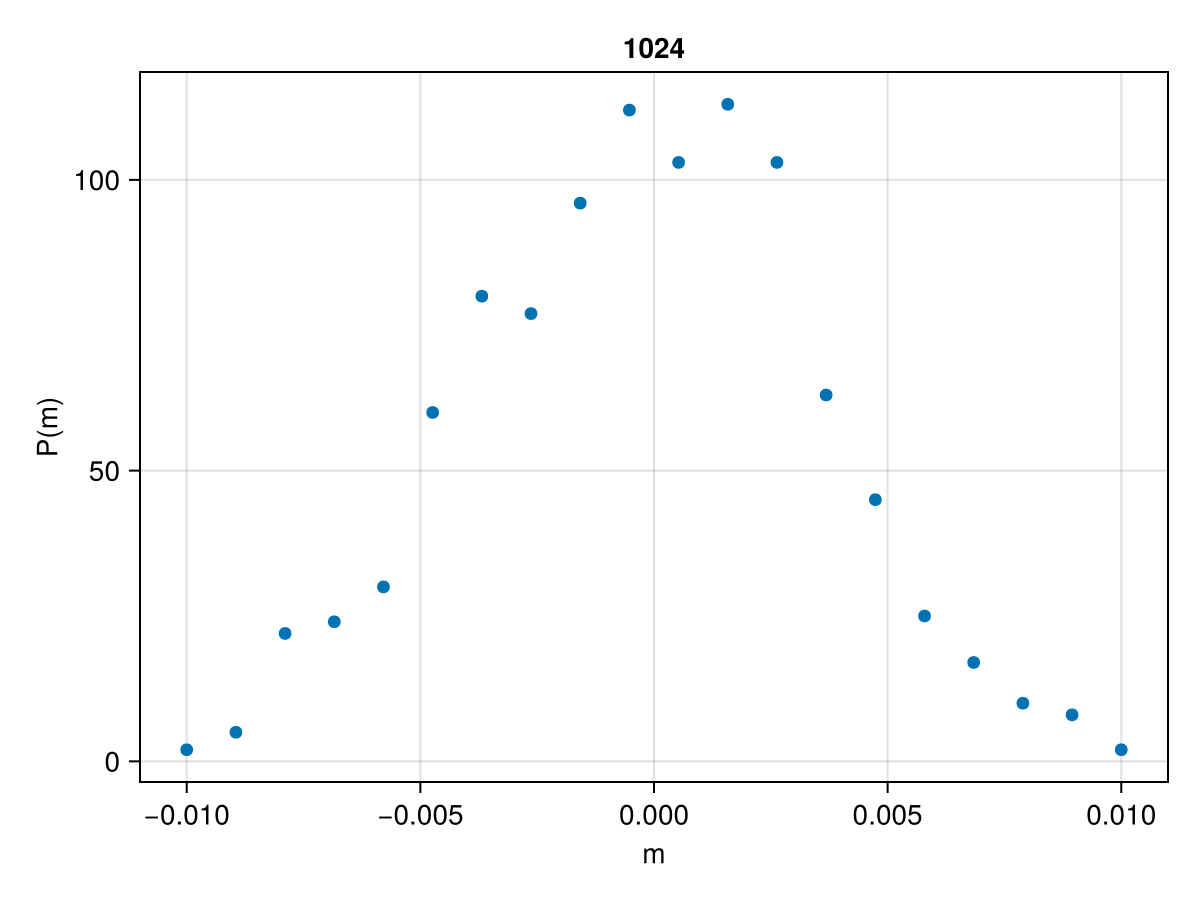

In [39]:
# Bin the data
htbins1024=Bin(-0.01,0.01,20)
for m in mht1024
    htbins1024(m)
end
mvals=range(-0.01,0.01,20)
plot(mvals,htbins1024.counts,axis=(xlabel="m",ylabel="P(m)",title="1024"))

That could very well be a Gaussian, but we need better statistics to be sure.  Since the correlation length is just 10's of sites, we can do a smaller system size -- say 64x64

  1.892583 seconds (148.04 k allocations: 114.515 MiB, 0.61% gc time)


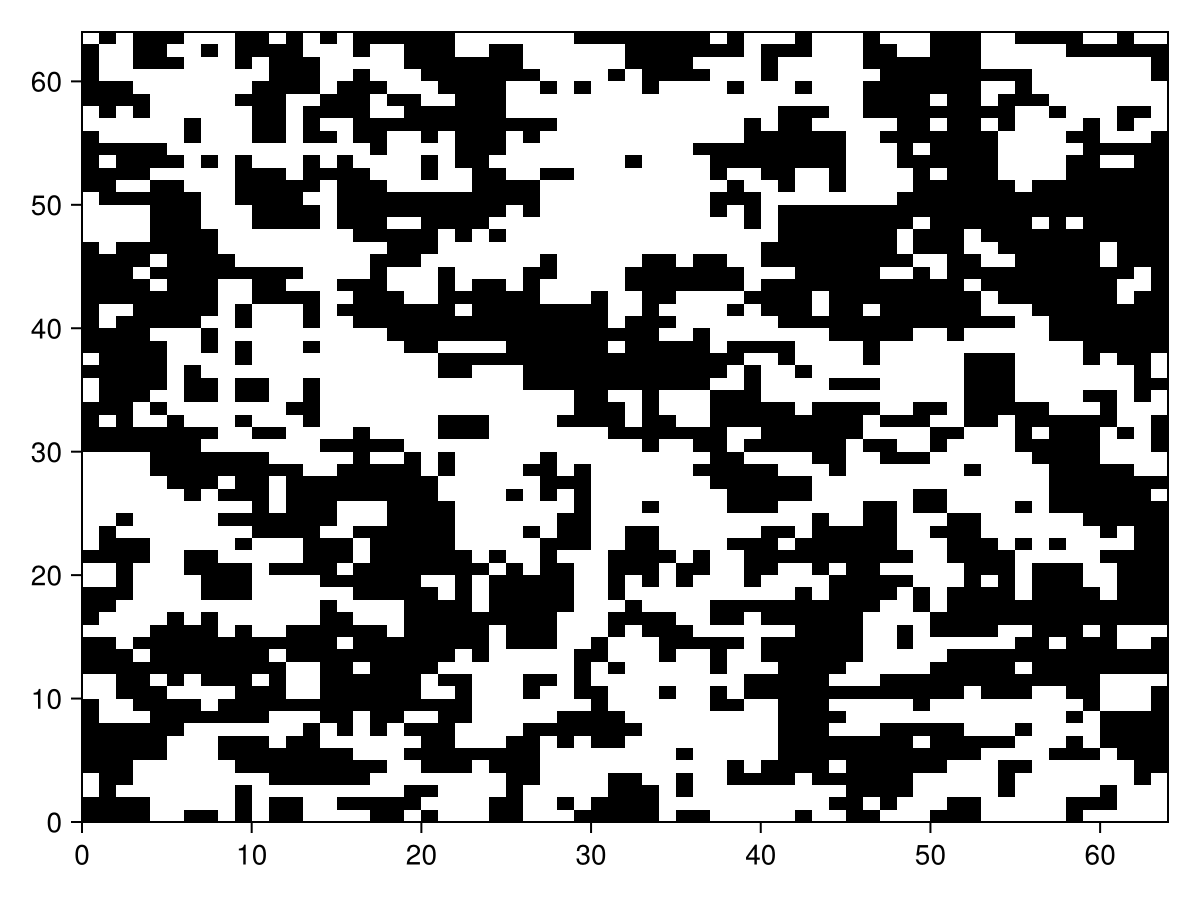

In [48]:
s64=rand_ising2d(64,64)
@time longsim64=fullsimulate!(s64,betahot,0.,10,40000)
im=image(s64,interpolate=false)

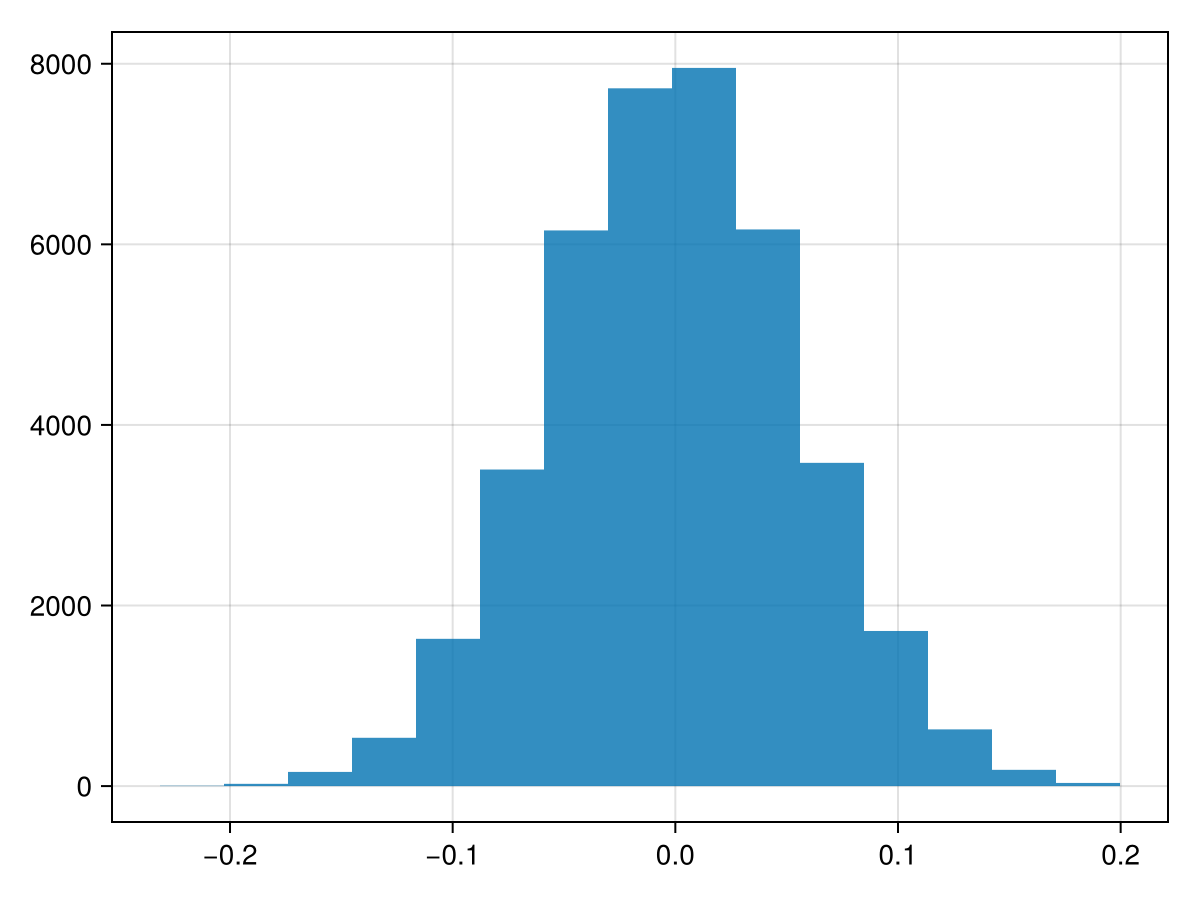

In [49]:
hist(longsim64.maglist)

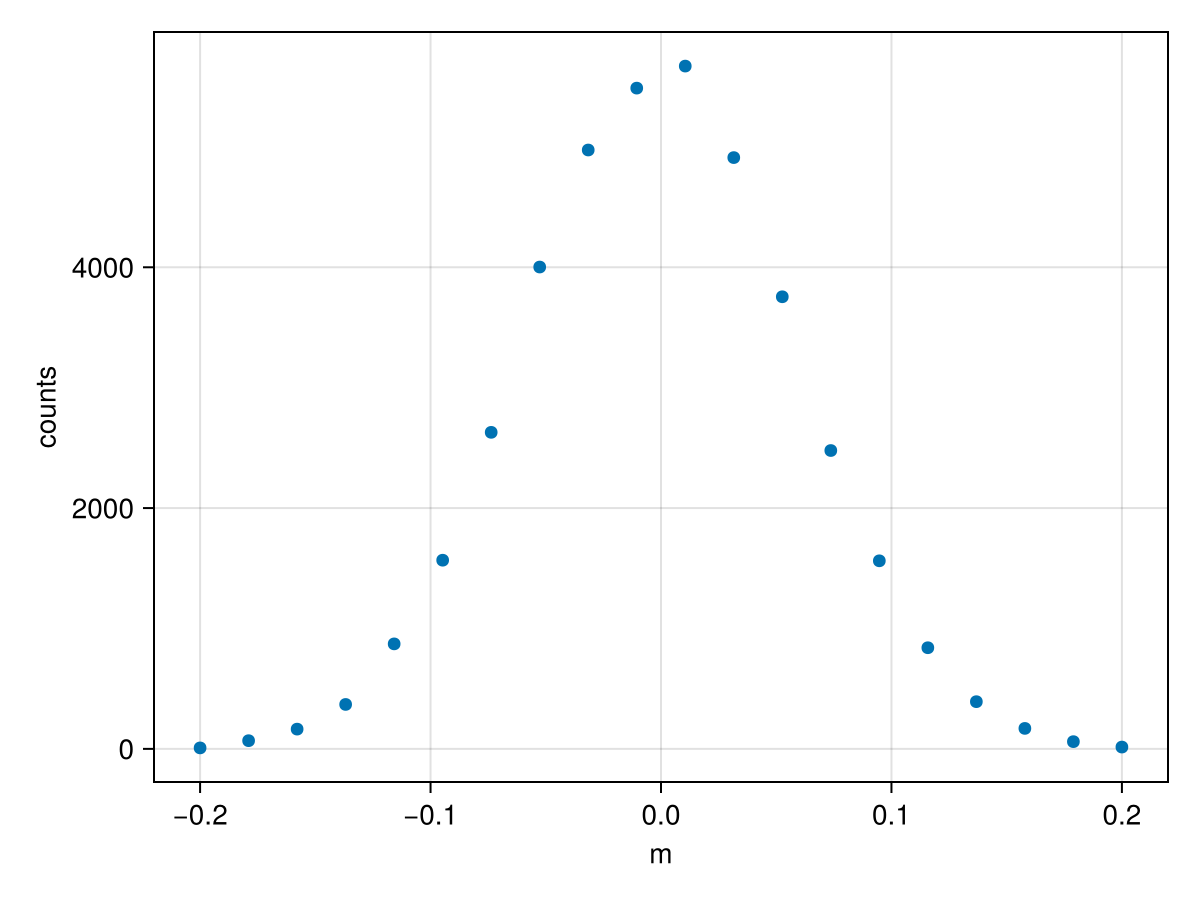

In [50]:
htbins64=Bin(-0.2,0.2,20)
for m in longsim64.maglist
    htbins64(m)
end
mvals=range(-0.2,0.2,20)
p=plot(mvals,htbins64.counts)
p.axis.xlabel="m"
p.axis.ylabel="counts"
p

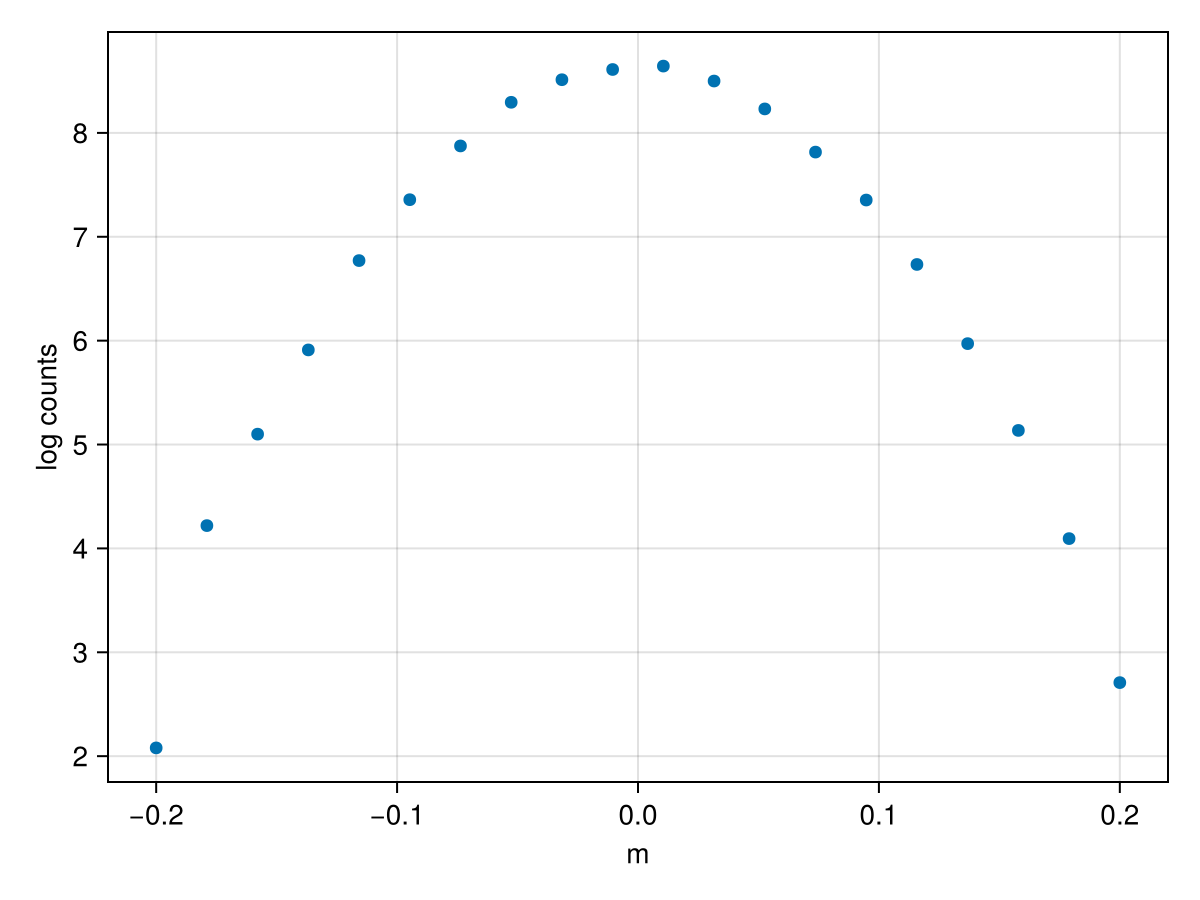

In [51]:
p=plot(mvals,log.(htbins64.counts))
p.axis.xlabel="m"
p.axis.ylabel="log counts"
p

Indeed that made a nice parabola.  We can turn this into a Free Energy density by

\begin{align}
F(m)&=-\frac{1}{\beta} \ln P(m)
\end{align}

An important feature is that multiplying the probability by a constant, adds a constant to $F$.  Typically we will work with a non-normalized probability distribution, and choose the constant so that the minimum of $F(m)$ is zero.

It is easy to code this up

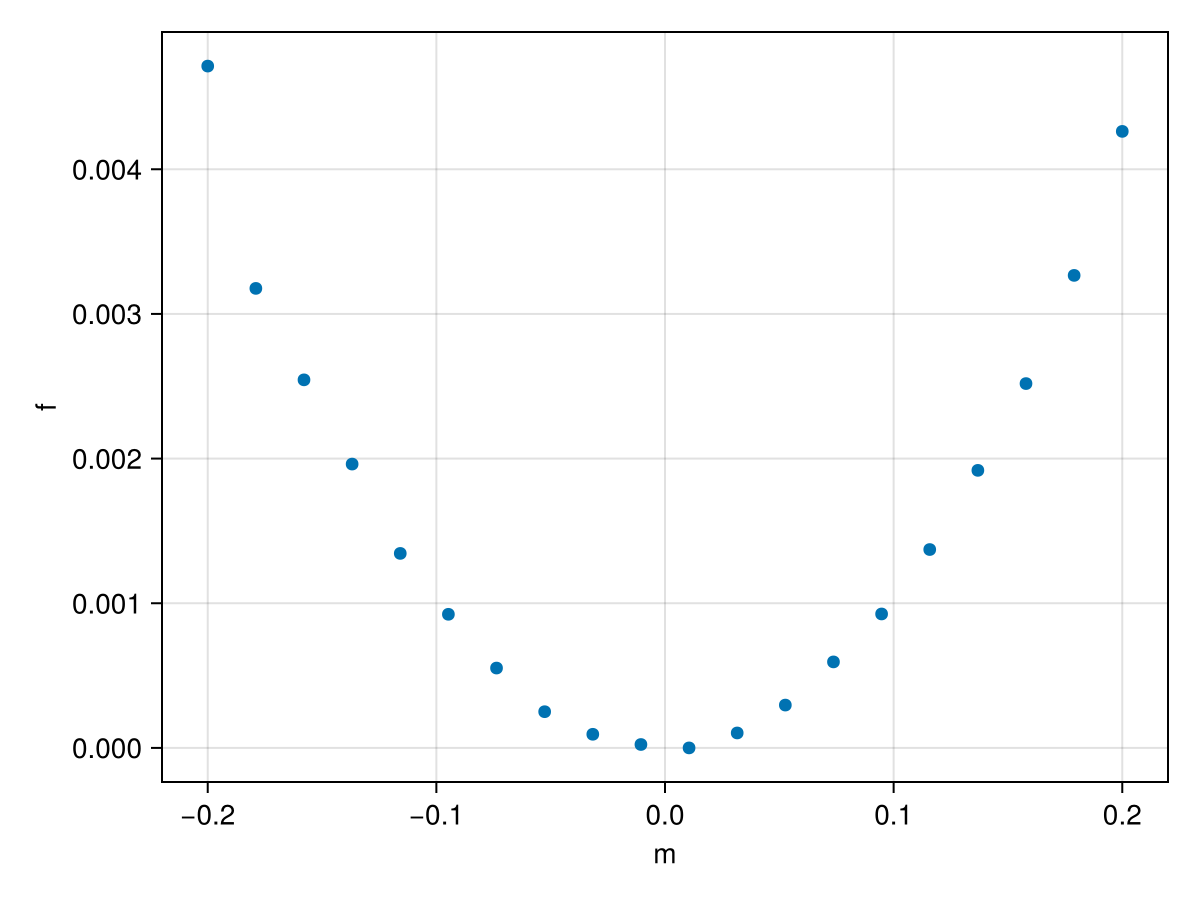

In [52]:
f64= @. (-1/betahot)*log(htbins64.counts)/(64^2)
f64min=min(f64...)
p=plot(mvals,f64.-f64min)
p.axis.xlabel="m"
p.axis.ylabel="f"
p

Lets do another system size to verify that the free energy density is indeed intensive.

  9.519006 seconds (159.98 k allocations: 148.035 MiB, 0.30% gc time)


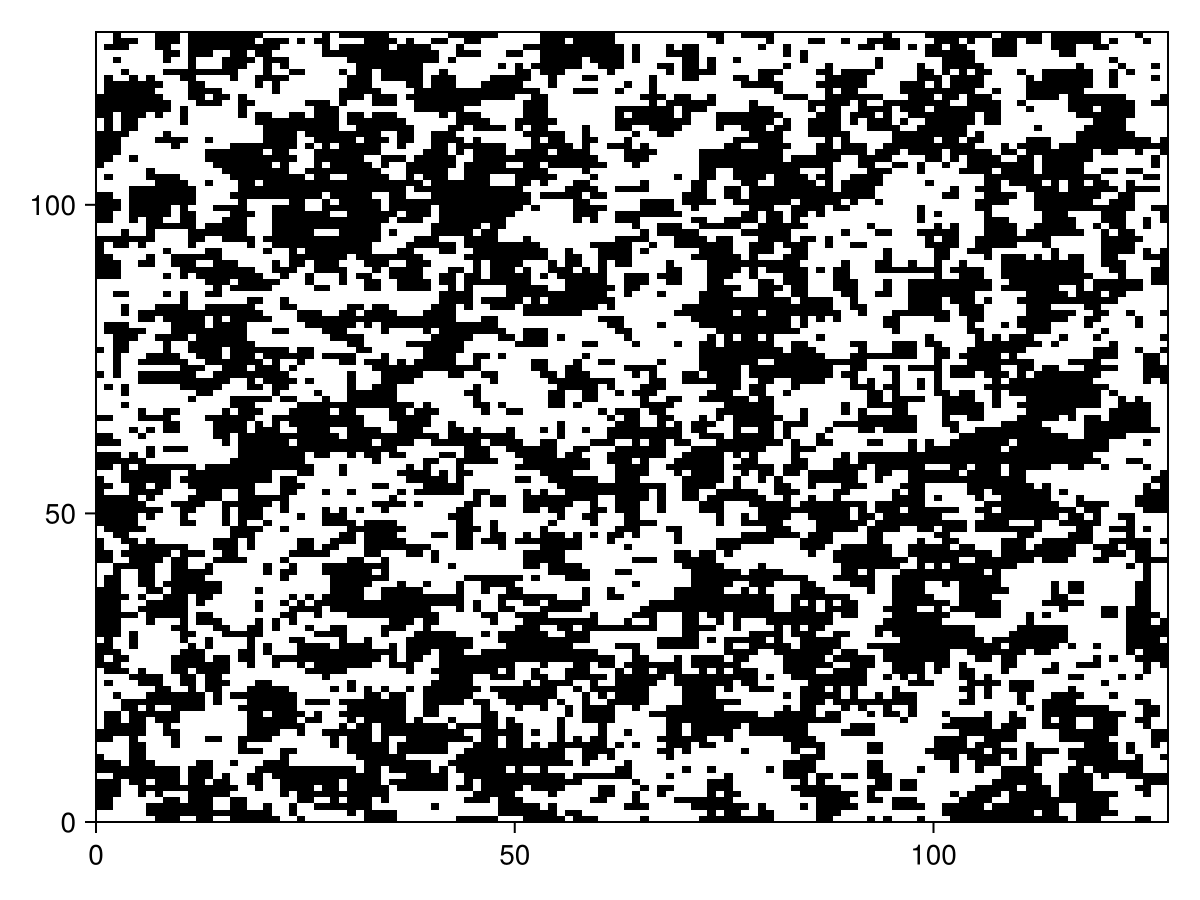

In [53]:
s128=rand_ising2d(128,128)
@time longsim128=fullsimulate!(s128,betahot,0.,10,40000)
im=image(s128,interpolate=false)

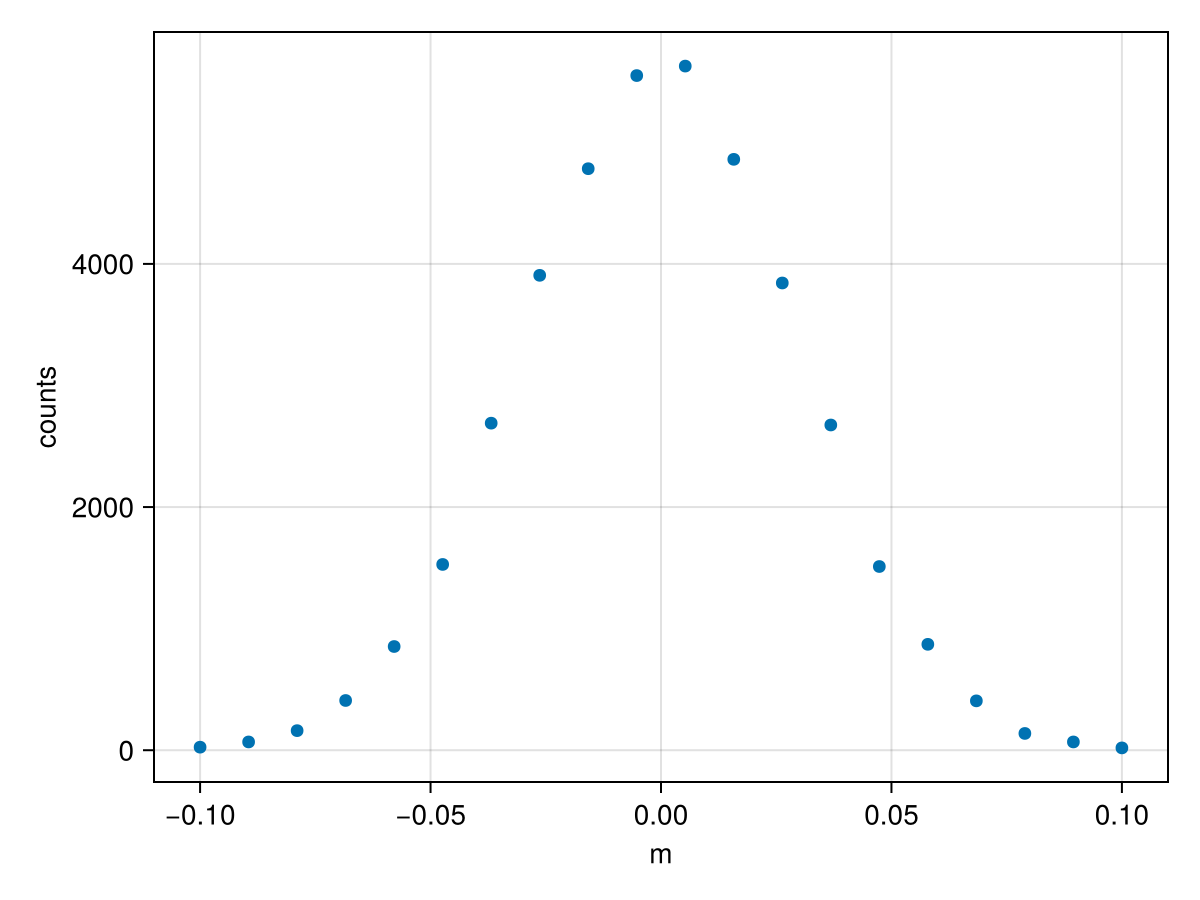

In [55]:
htbins128=Bin(-0.1,0.1,20)
for m in longsim128.maglist
    htbins128(m)
end
mvals128=range(-0.1,0.1,20)
p=plot(mvals128,htbins128.counts)
p.axis.xlabel="m"
p.axis.ylabel="counts"
p

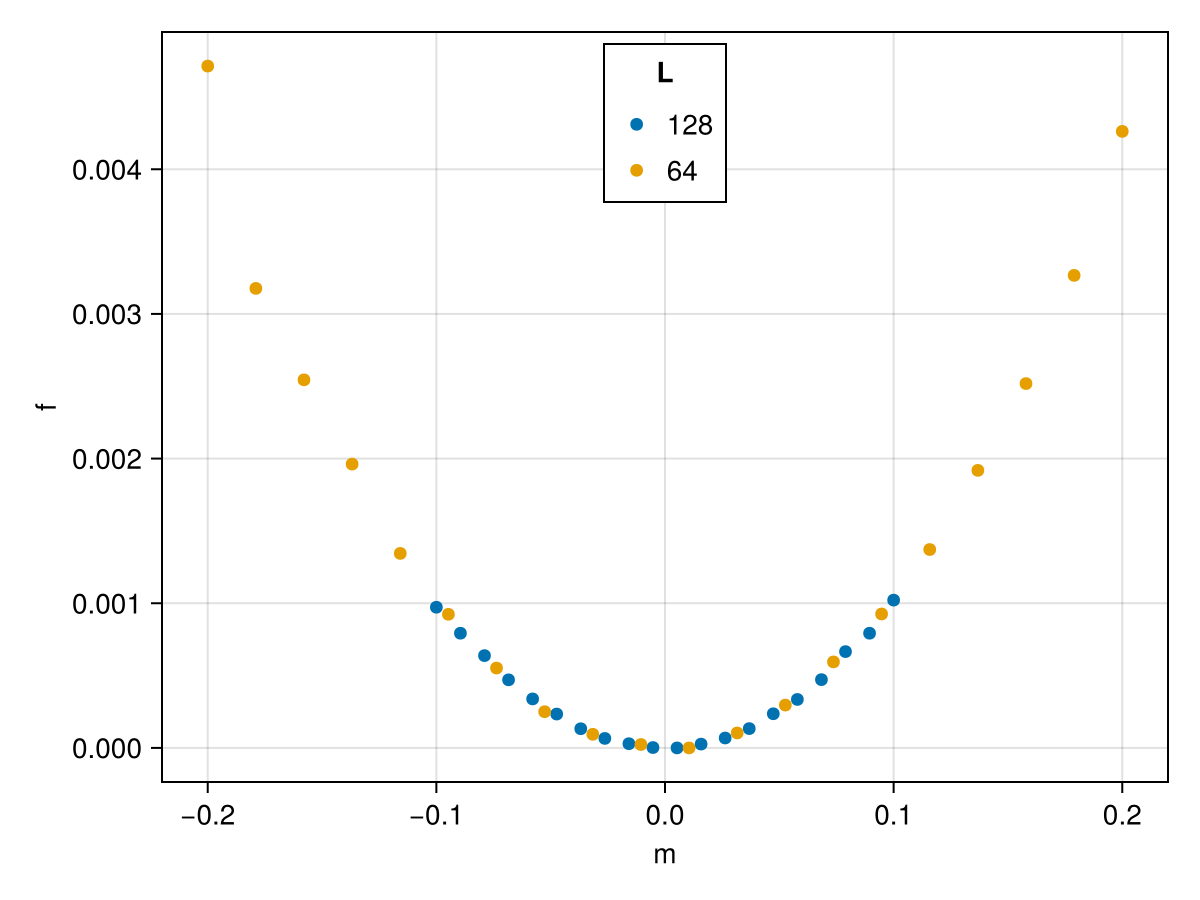

In [56]:
f128= @. (-1/betahot)*log(htbins128.counts)/(128^2)
f128min=min(f128...)
p=plot(mvals128,f128.-f128min,label="128")
plot!(mvals,f64.-f64min,label="64")
p.axis.xlabel="m"
p.axis.ylabel="f"
axislegend(position = :ct,"L")
p

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Mini Lab 1
</h2>

Make a function 

    function freeenergy(timeseries,beta,numspins,minx,maxx,numbins)

which takes the following arguments:

* `timeseries` -- a list of magnetizations
* `beta` -- the inverse temperature
* `numspins` -- the total number of spins in the simulation
* `minx` -- the start of the lowest bin
* `maxx` -- the end of the highest bin
* `numbins` -- the number of bins

It should return the following tuple

    return (xvals=xvals,fvals=fvals)

here `xvals` is the midpoints of the bins, `fvals` is the free energy density at that value of the magnetization.

Test by reproducing that last graph.

<div style="border: 2px solid white; border-radius: 10px; padding: 20px; background-color:white; color:black; height: 500px" >
</div>

In [57]:
# My version
function freeenergy(timeseries,beta,numspins,minx,maxx,numbins)
    bin=Bin(minx,maxx,numbins)
    for x in timeseries
        bin(x)
    end
    binedges=range(minx,maxx,numbins)
    bincenters=(binedges[2:end]+binedges[1:end-1])/2
    counts=bin.counts
    xvals=[]
    fvals=[]
    err=[]
    maxcount=max(counts...)
    for j in 1:length(bincenters)
        c=counts[j]
        if c>0
            f=(-1/beta)*log(c/maxcount)/(numspins)
            df=-1/(beta*numspins*sqrt(c))
            append!(xvals,bincenters[j])
            append!(fvals,f)
            append!(err,df)
        end
    end
    return (xvals=[xvals...],fvals=[fvals...],err=[err...])
end 

freeenergy (generic function with 1 method)

Some things to note about my version:

1. I also estimate the error -- assuming the fluctuations are Poissonian
2. In my return statement I used `xvals=[xvals...]` -- which will convert the `Array{Any}` object into `Array{Float64}`.

An important feature is that the free energy density should not depend on our choice of bins.

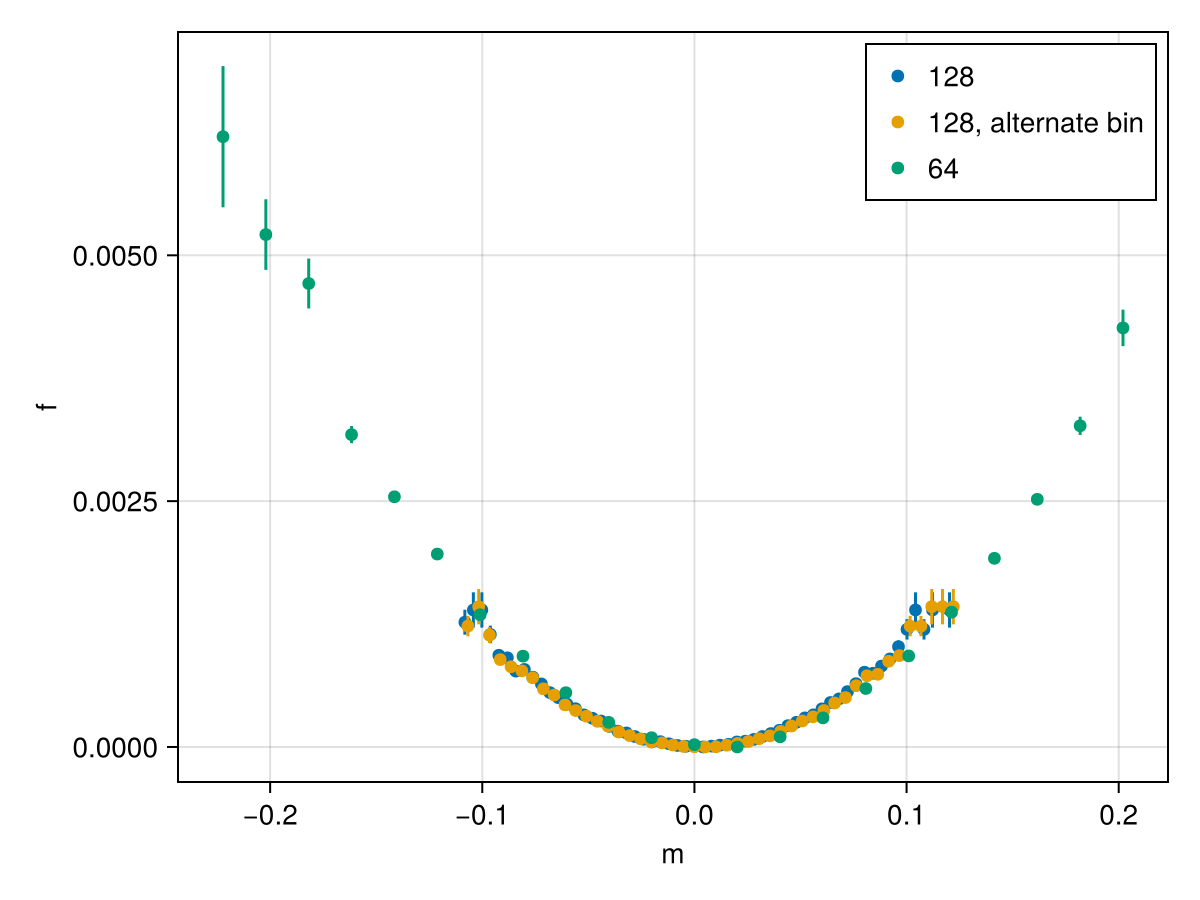

In [58]:
f128=freeenergy(longsim128.maglist,betahot,128^2,-1.,1.,500)
f128b=freeenergy(longsim128.maglist,betahot,128^2,-0.15,0.15,60)
f64=freeenergy(longsim64.maglist,betahot,64^2,-1.,1.,100)
p=plot(f128.xvals,f128.fvals,label="128")
errorbars!(f128.xvals,f128.fvals,f128.err)
plot!(f128b.xvals,f128b.fvals,label="128, alternate bin")
errorbars!(f128b.xvals,f128b.fvals,f128b.err)
plot!(f64.xvals,f64.fvals,label="64")
errorbars!(f64.xvals,f64.fvals,f64.err)
p.axis.xlabel="m"
p.axis.ylabel="f"
axislegend()
p

## Free energy at low temperature

The argument for the Free Energy at low temperature is the same, but now there is an average magnetization in each independent cluster, so the probability distribution is two Gaussians -- centered around $m_0$ and $-m_0$.

Lets illustrate this with a temperature which is just a little above the transition.  To get good statistics we will take 200,000 realizations

 33.736318 seconds (979.57 k allocations: 5.389 GiB, 1.85% gc time)


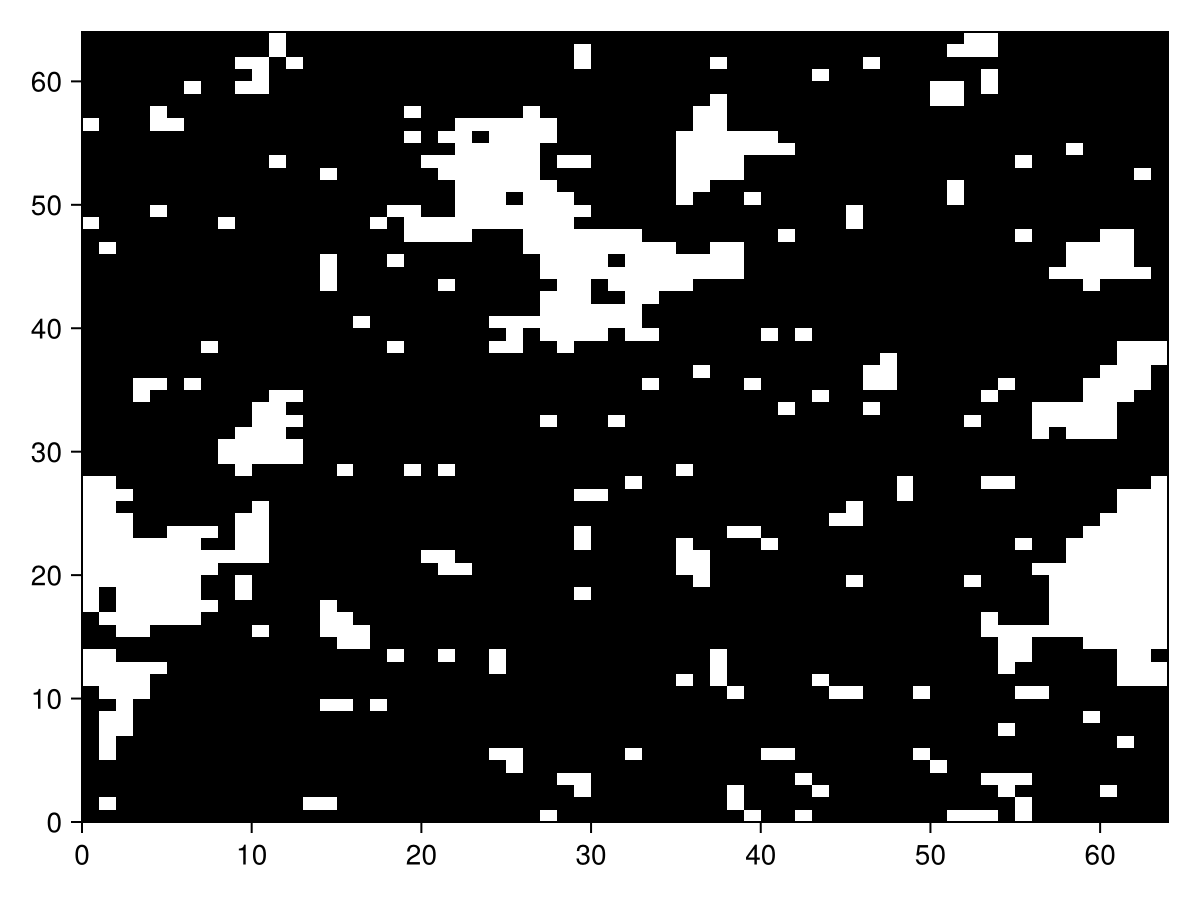

In [59]:
s64=rand_ising2d(64,64)
@time lowTsim64=fullsimulate!(s64,0.445,0.,10,200000)
im=image(s64,interpolate=false)

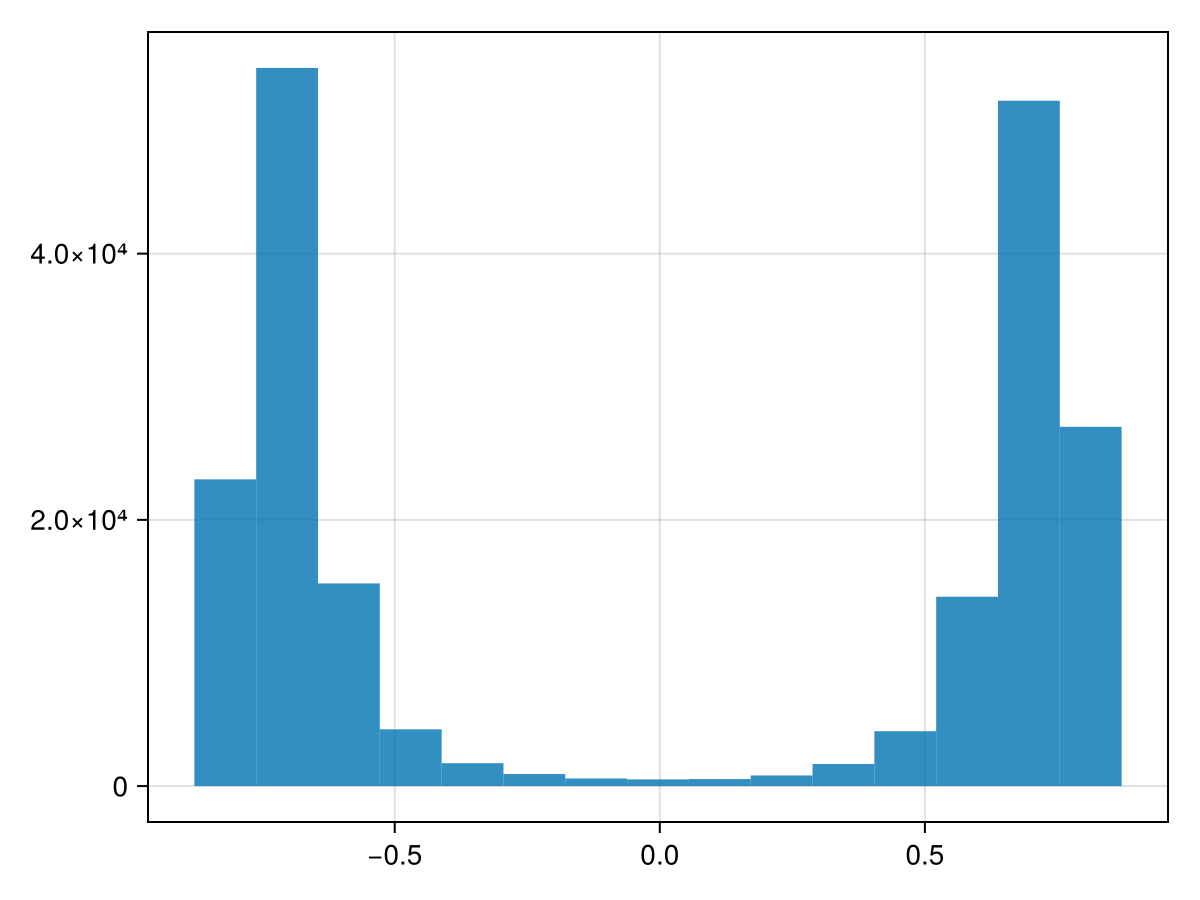

In [62]:
hist(lowTsim64.maglist)

Now we can use our `freeenergy` function to plot the free energy

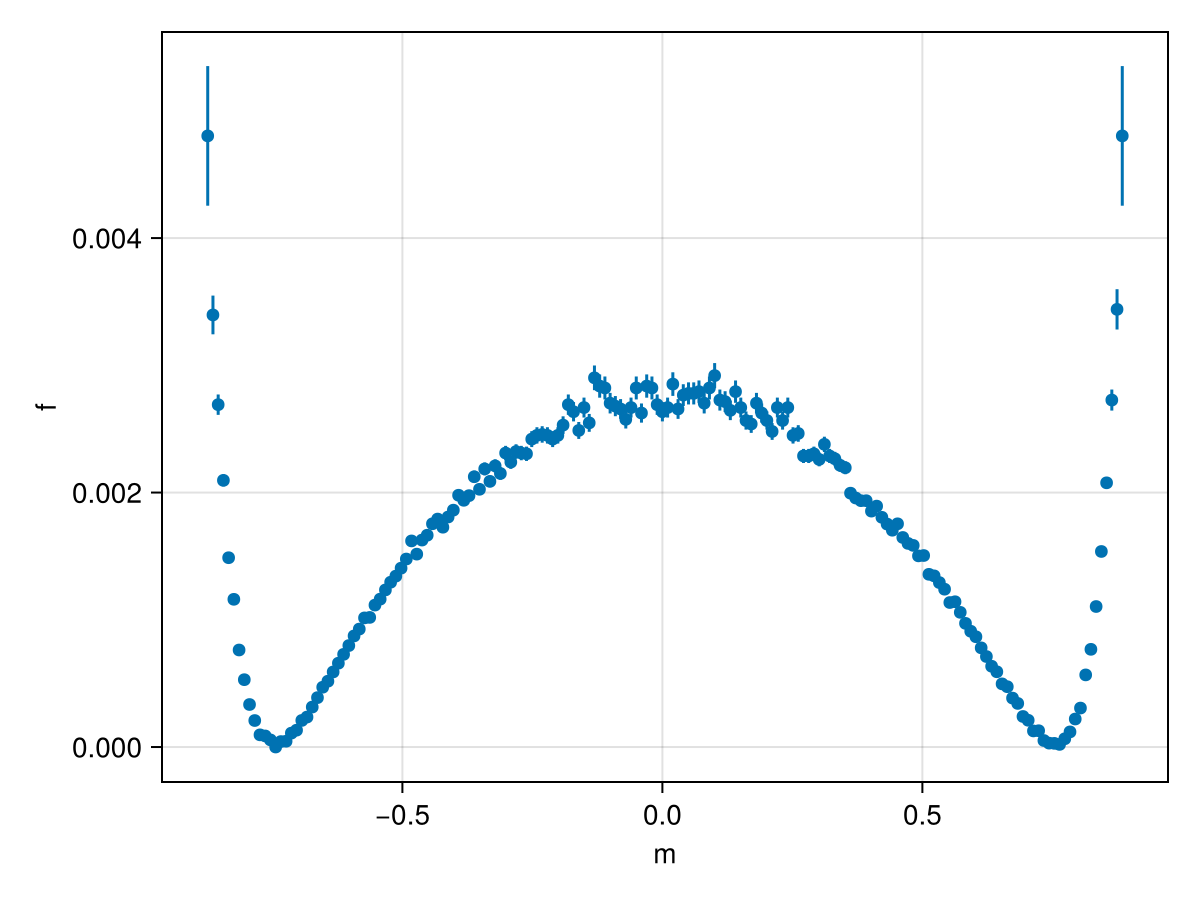

In [63]:
ltm64,ltf64,lte64=freeenergy(lowTsim64.maglist,0.445,64^2,-1.,1.,200)
p=plot(ltm64,ltf64)
errorbars!(ltm64,ltf64,lte64)
p.axis.xlabel="m"
p.axis.ylabel="f"
p

As you consider larger and larger systems, only the behavior of $f$ near the minima matter.  As you approach the transition point these minima become closer and closer, eventually merging.

## More detailed view of free energy

To better visualize things, lets generate a set of data for $\beta$ between 0.4 and 0.5, with 100000 realizations.

In [ ]:
#for j in 3:8
#    println("generating data for j="*string(j))
#    @time data=tempsweep(2^j,2^j,0.4,0.5,0.01,10,100000)
#    filename="hr"*string(j)*".h5"
#    savesweep(data,filename)
#    println("saved data in file "*string(filename))
#    println()
#end

In [66]:
hrdatafile=["hr"*string(j)*".h5" for j in 3:8]

6-element Vector{String}:
 "hr3.h5"
 "hr4.h5"
 "hr5.h5"
 "hr6.h5"
 "hr7.h5"
 "hr8.h5"

In [67]:
hrdata=[loadsweep(file) for file in hrdatafile];

Here is an example of accessing the time-series data:

    hrdata[ which system size ].maglists[ which beta ]

So to look at two different temperatures for the largest system size:

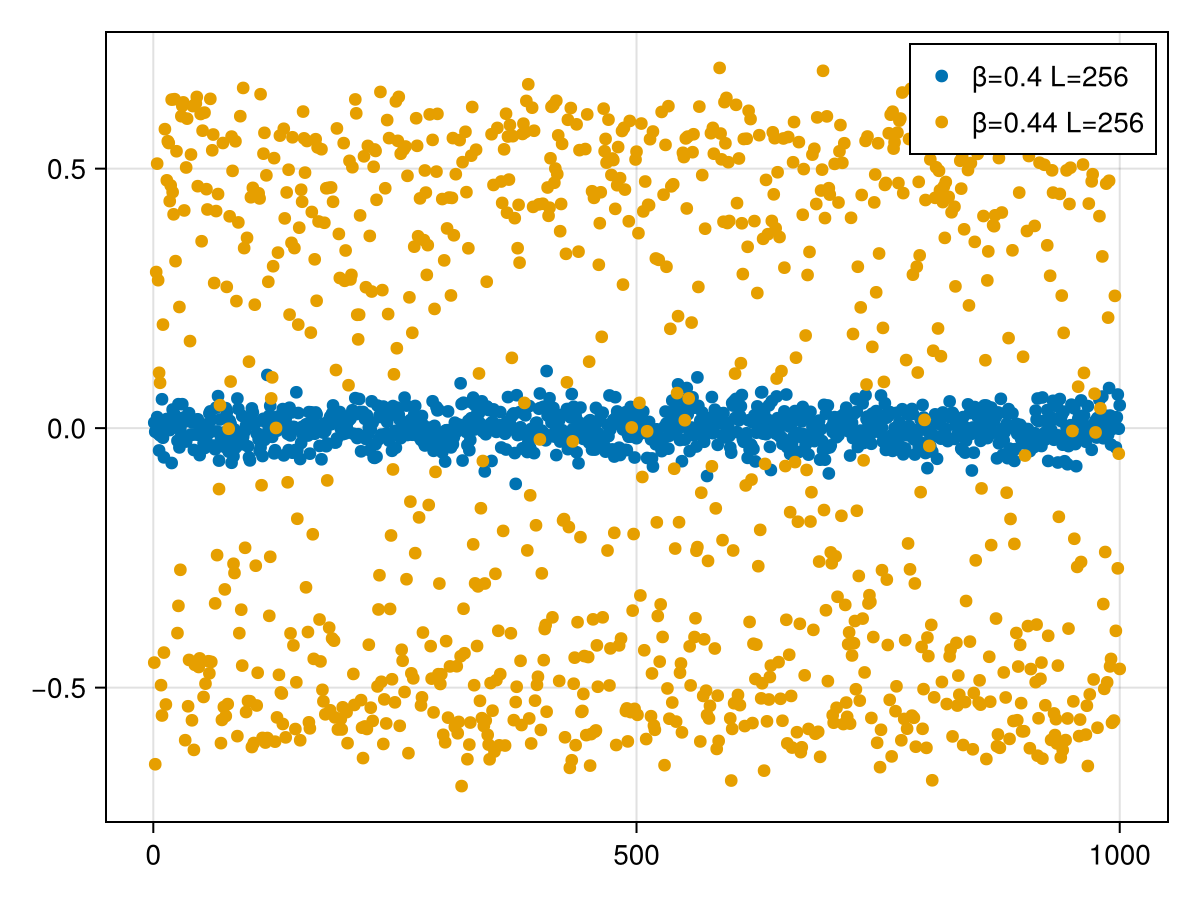

In [72]:
p=plot(hrdata[end].maglists[1][1:100:end],
    label="β="*string(round(hrdata[end].betas[1],sigdigits=2))*" L="*string(hrdata[end].arraysize[1]))
plot!(hrdata[end].maglists[5][1:100:end],
    label="β="*string(round(hrdata[end].betas[5],sigdigits=2))*" L="*string(hrdata[end].arraysize[1]))
axislegend()
p

Now lets step through our new high resolution data, plotting the free energy for each beta.  We will just do the 2 largest systems (128x128 and 256x256)

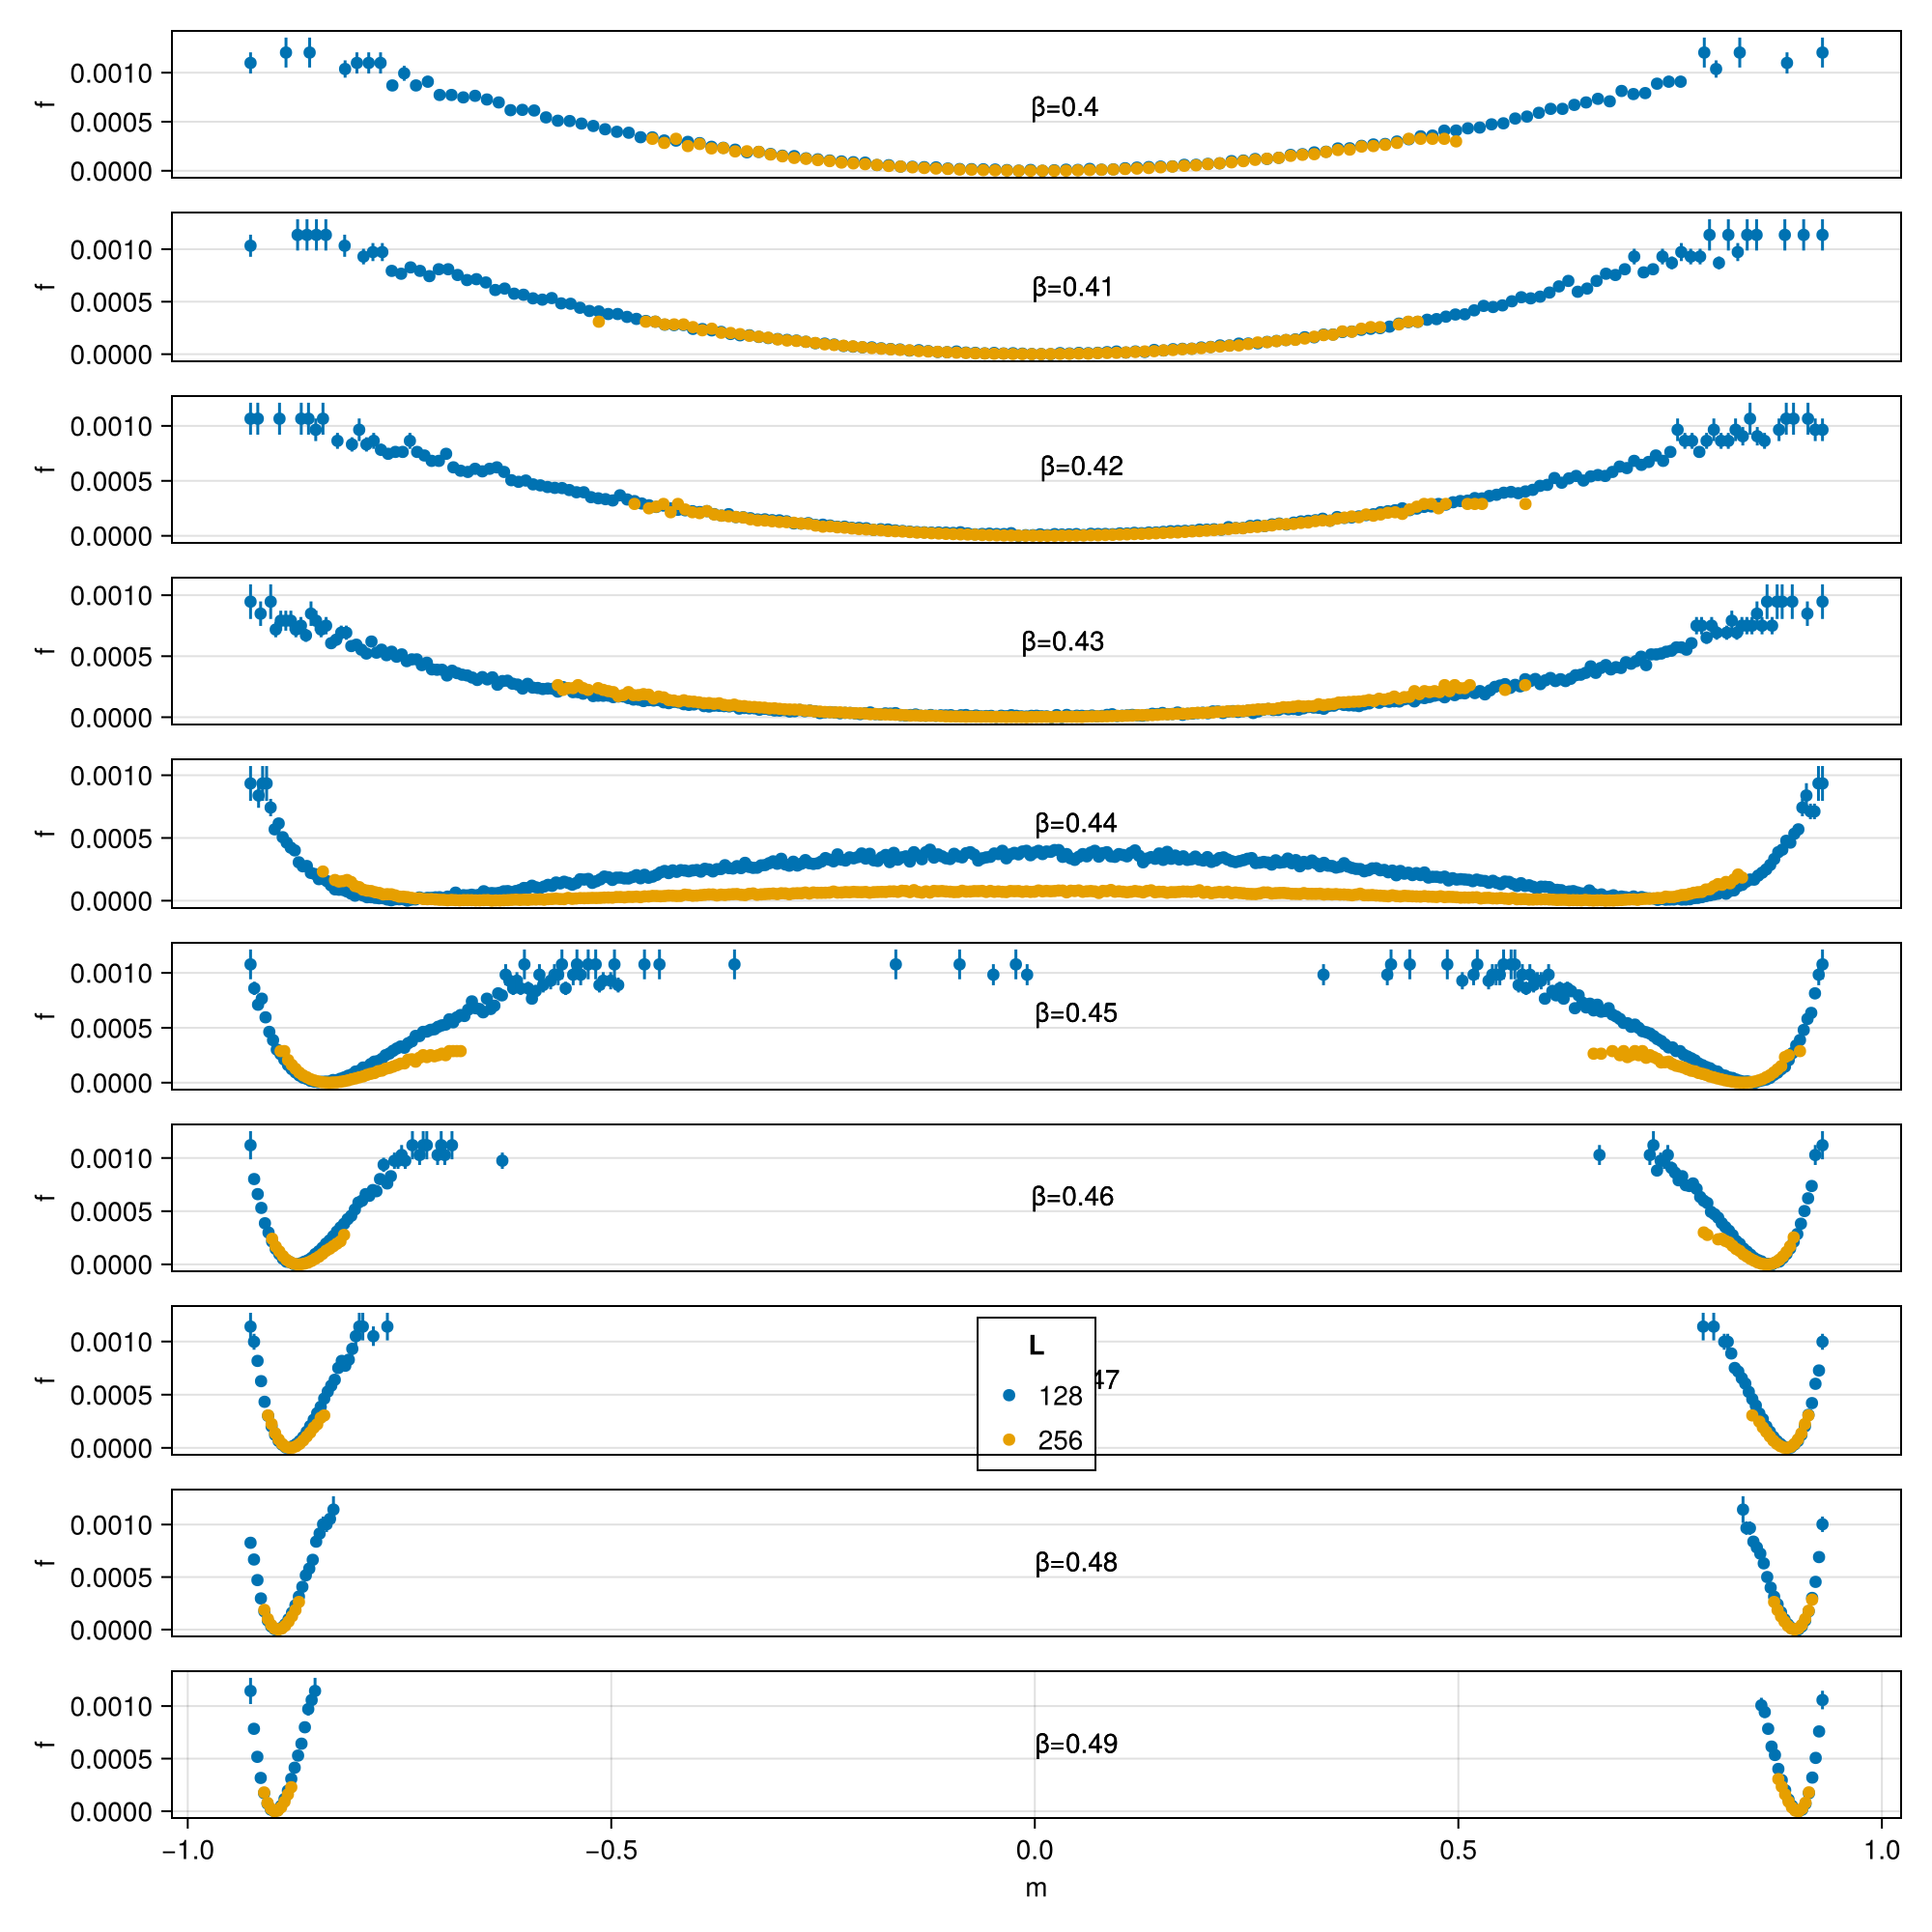

In [73]:
fig=Figure(size=(1000,1000))
betas=[hrdata[1].betas...]
sizes=[d.arraysize[1] for d in hrdata]
numbetas=length(betas)
numsizes=length(sizes)
for jb in 1:numbetas
    ax=Axis(fig[jb,1],xlabel="m",ylabel="f")
    #ylims!(ax,[0,0.01])
    for js in numsizes-1:numsizes
        f=freeenergy(hrdata[js].maglists[jb],betas[jb],sizes[js]^2,-1.,1.,500)
        plot!(ax,f.xvals,f.fvals,label=string(sizes[js]))
        errorbars!(ax,f.xvals,f.fvals,f.err)
        text!(ax,position=(0,0.0005),"β="*string(round(betas[jb],sigdigits=2)))
    end
    if jb<numbetas
       hidexdecorations!(ax) 
    end
    if jb==numbetas-2
        axislegend(ax,position = :ct,"L")
    end
end
fig

At high temperature the Free Energy has a minimum at m=0, and the different size data lands on top of one-another.  At low temperature, the minimum is at finite m, and again the different sizes land on top of eachother.  This is because the system is large compared to the correlation length.

At $\beta=0.44$ and $\beta=0.45$ we see that the two free energies do not agree with one-another.  This size dependence is characteristic of critical behavior.  

## Domain Walls

Lets look more closely at the structure of the free energy near the critical point.  Lets focus on the case $\beta=0.46$, which is certainly in the ordered phase -- but is close to the transition.  We clearly see in the above plot that the L=128 and L=256 data collapse very nicely here.  But -- we see definite signs of non-gaussian behavior of the L=128 data.

Lets look at the smaller size samples as well:

In [74]:
betas[7]

0.4600000000000001

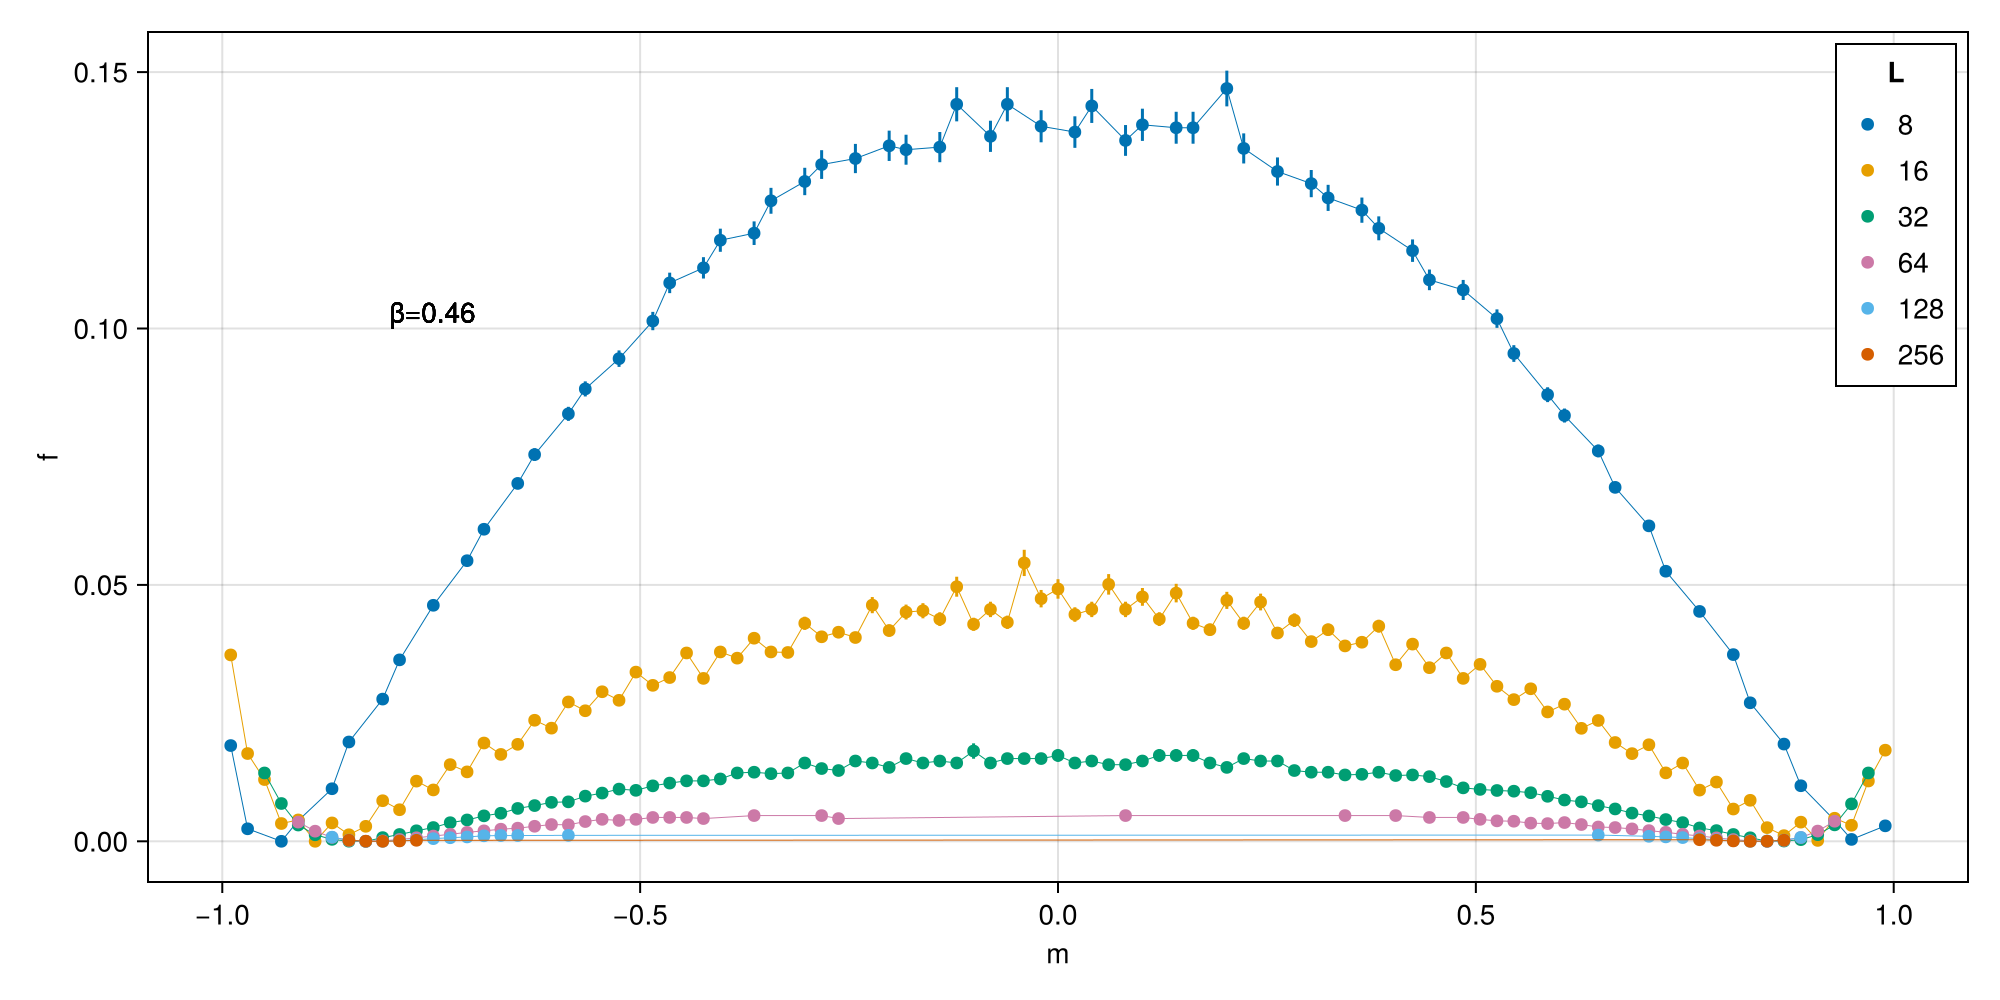

In [80]:
fig=Figure(size=(1000,500))
betas=[hrdata[1].betas...]
sizes=[d.arraysize[1] for d in hrdata]
numbetas=length(betas)
numsizes=length(sizes)
jb=7 # use beta=0.46
ax=Axis(fig[1,1],xlabel="m",ylabel="f")
for js in 1:numsizes
    f=freeenergy(hrdata[js].maglists[jb],betas[jb],sizes[js]^2,-1.0,1.0,100)
    plot!(ax,f.xvals,f.fvals,label=string(sizes[js]))
    lines!(ax,f.xvals,f.fvals,linewidth=0.5)
    errorbars!(ax,f.xvals,f.fvals,f.err)
    text!(ax,position=(-0.8,0.1),"β="*string(round(betas[jb],sigdigits=2)))
end
axislegend(ax,position = :rt,"L")
fig

Apparently the probability of the "rare" m=0 configurations is strongly $L$ dependent.

This is because those configurations contain domain walls which divide the system into macroscopic domains.  The domain wall energy should be proportional to the length of the wall -- which scales with system size.  The resulting free energy gets sub-extensive corrections.

Interestingly -- it looks like the data collapses if we multiply the Free Energy by $L^{3/2}$

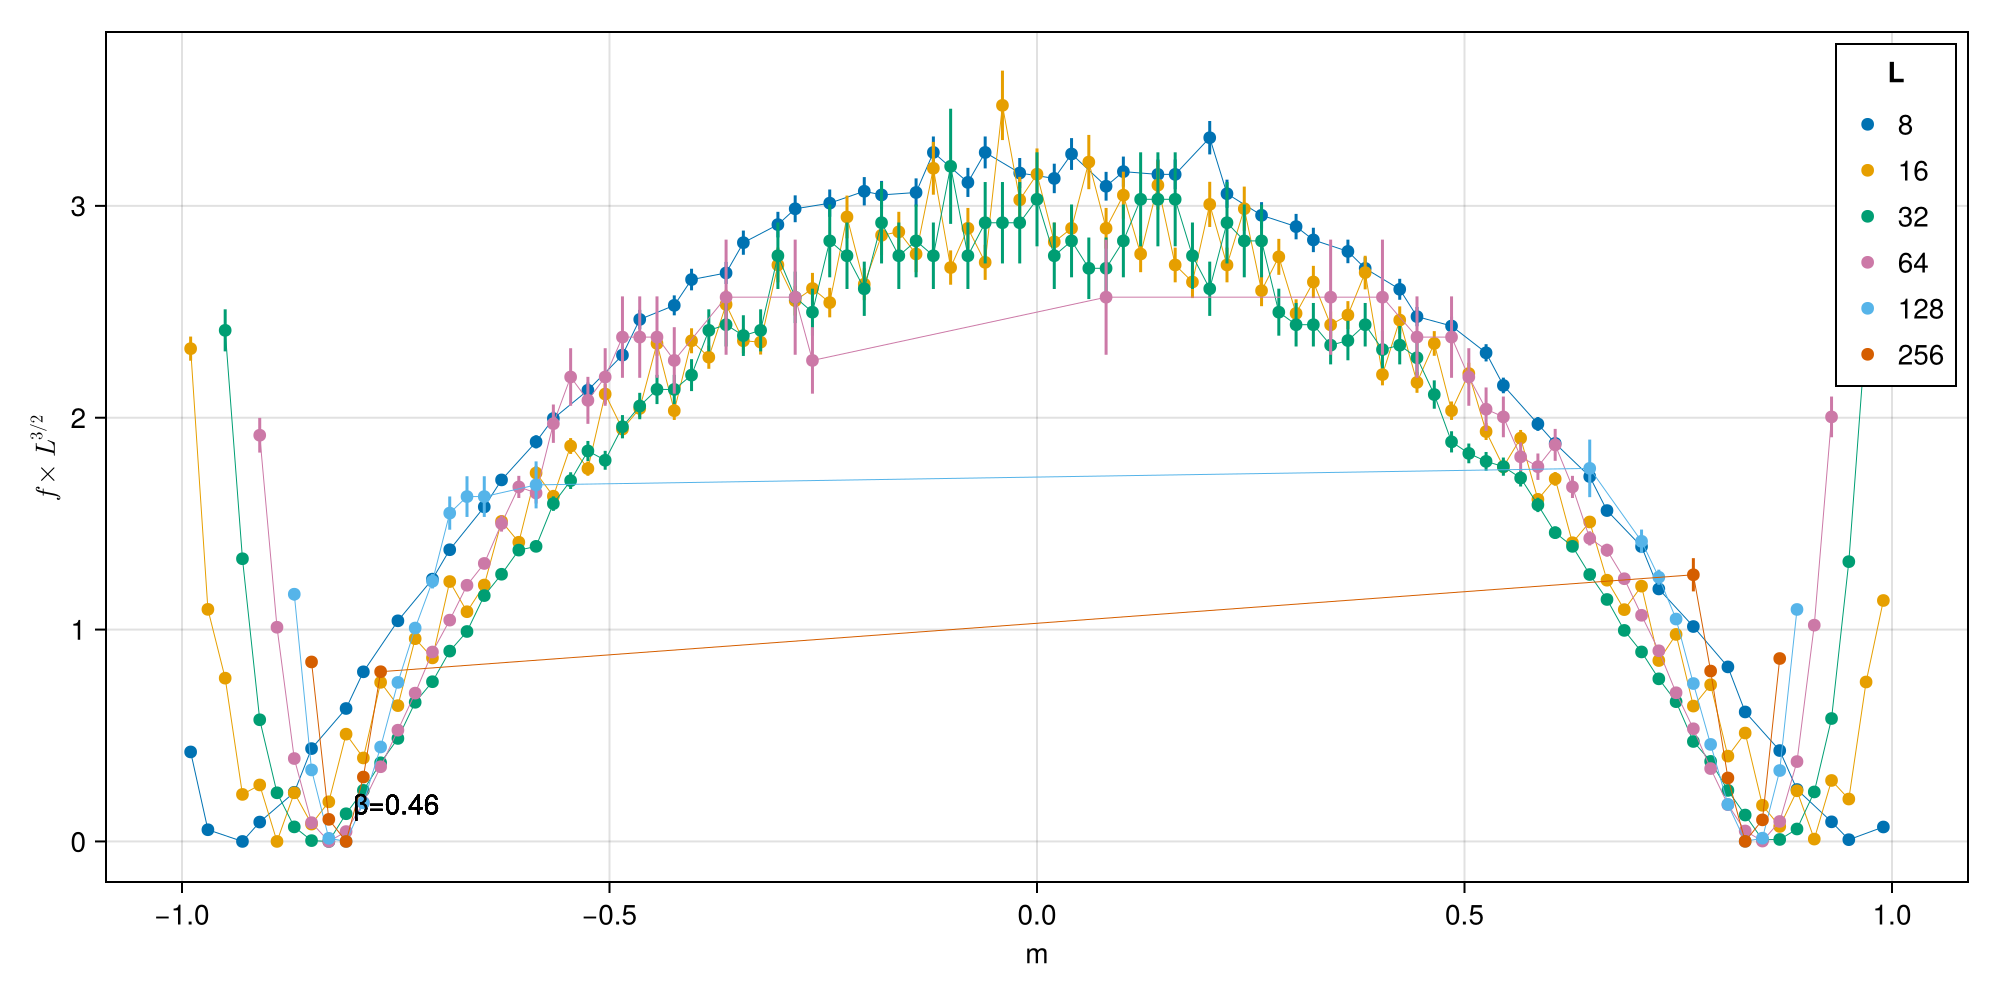

In [85]:
fig=Figure(size=(1000,500))
betas=[hrdata[1].betas...]
sizes=[d.arraysize[1] for d in hrdata]
numbetas=length(betas)
numsizes=length(sizes)
jb=7 # use beta=0.46
ax=Axis(fig[1,1],xlabel="m",ylabel=L"f\times L^{3/2}")
for js in 1:numsizes
    f=freeenergy(hrdata[js].maglists[jb],betas[jb],sizes[js]^2,-1.0,1.0,100)
    plot!(ax,f.xvals,f.fvals.*sizes[js]^(3/2),label=string(sizes[js]))
    lines!(ax,f.xvals,f.fvals.*sizes[js]^(3/2),linewidth=0.5)
    errorbars!(ax,f.xvals,f.fvals.*sizes[js]^(3/2),f.err.*sizes[js]^(3/2))
    text!(ax,position=(-0.8,0.1),"β="*string(round(betas[jb],sigdigits=2)))
end
axislegend(ax,position = :rt,"L")
fig